# Evooq code challenge


The goal is to build up few ML models in order to develop future features in a microservice based system. We provide you some data accessible in different ways. Accessing them and pre-process them is a major part of the exercise on which we will have a particular look.

***context***

We want to build few features based on financial data.

We don’t assume any particular financial knowledge to solve this problem.

Here are the different concept we will use:

- Client: A client has an account in a bank

- Asset: An asset is the description of a financial product. It is referenced by an ISIN and can be of different types like "Equity", "Bond", …

- Issuer: An issuer is an organization (company, government, …​) that issues assets. Each asset has an issuer.

- Preference measure: We made a random poll regarding client’s preferences for assets they already owned in the past, these are the collected results.


## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup
import json
import simplejson
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats as ss




plt.rcParams['font.size'] = '15'


# Functions

In [2]:
def get_assests_from_page(PAGE =1):
    
    """Input : Takes the page number of a HTML file"""
    """Output :  Return all the assets in dataframe fromat """
    
    
    ## URL to the page after connecting to the asset server
    assets_link = 'http://localhost:8080/assets?page={};key=cb6052ba-53d4-45a7-839a-28b748e0afc9'.format(PAGE)
    
    ## Requesting the html text
    r = requests.get(assets_link)
    assets_json = r.text
    
    ## Parsing the text to get a list of dictionaries
    n = len(assets_json)
    assets_list = assets_json[1:n-1].split('}')
    
    ## Turnining the list of dictionaries to a a dataframe
    asset_0 = json.loads(assets_list[0]+ '}')
    assets_df = pd.DataFrame(asset_0, index = [0])

    for asset in assets_list[1:-1]:
        asset = json.loads(asset[1:]+'}')
        asset_df = pd.DataFrame(asset, index = [0])
        assets_df = pd.concat([assets_df,asset_df])
    
    ## reseting the index
    assets_df = assets_df.reset_index()
    assets_df = assets_df.drop(columns = ['index'], axis=1)
    
    return assets_df

In [3]:
def get_df_from_sql_table(TABLE : str , Column_names : list):
    
    '''Input : Takes the table name in the database and the name of the pandas dataframe columns  '''
    '''Output : pandas dataframe with the given columns names  '''
    
    sql = ' SELECT* FROM {}'.format(TABLE)
    mycursor.execute(sql)
    myresult = mycursor.fetchall()
    
    df = pd.DataFrame(myresult, columns = Column_names)
    

    
    return df

In [4]:
## Extracting the currancy from the name if it exists

def intersection(lst1, lst2):
    
    """ Gives the intersection of two lists"""
    return list(set(lst1) & set(lst2))



def extract_value_from_name(asset_name, list_words):
    
    """If a word from the list_words exists in the string asset_name it will be returned by the function"""
    """Othewise an na will be returned"""
    
    ## Removing special chracters 
    asset_name = re.sub('[^A-Za-z\s]+', '', str(asset_name))
    
    ## Uppercase all words
    words_list = asset_name.upper().split(' ')
    
    inetrsection_lists = intersection(words_list, list_words)
    
    if len(inetrsection_lists) == 0 :
        
        return 'na'
    else:
        
        return inetrsection_lists[0]
    
    
    

# Part I : Import datasets

In this section we will read and extract different datasets

In [5]:
### Getting the working directory
directory = os.getcwd()

### Getting the existing files
files = os.listdir(directory)

In [6]:
files

['clients.csv',
 'clients.xlsx',
 'Evooq coding challenge.ipynb',
 'measures.csv',
 'instructions.html',
 '.ipynb_checkpoints']

### Importing clients and measures data

In [7]:
## import clients data

clients = pd.read_csv(directory + '/clients.csv', sep =';', header=0,  names = ['client_id', 'age', 'net income in CHF', 'country_id'])


## import  preference measures

measures = pd.read_csv(directory + '/measures.csv', sep =';',header=0, names = ['client_id', 'asset_id', 'score'])


In [8]:
clients.head(3)

,client_id,age,net income in CHF,country_id
0,2076663f-998b-201b-cb18-af7d314fa4fb,62,172198.128533,CH
1,a8ac18ac-deff-1ac7-0962-bb0188525840,55,108586.151459,CH
2,2de3d841-cc0c-ac5a-3b2b-2d918a5c9f2b,27,111124.341245,CH


In [9]:
measures.head(3)

,client_id,asset_id,score
0,306d09ec-eec2-f0d7-e303-990d17c17d51,cfbea06f-7eb2-4580-9556-e6a83f7bfd8a,0.921564
1,306d09ec-eec2-f0d7-e303-990d17c17d51,23abcc26-40ef-4619-9792-5c49174c79cd,0.861499
2,3fb6b173-07b2-5d4f-1879-7745243be968,5d23d1cc-d8bf-47da-927f-801c22bf7914,0.921587


Here we see that some IDs starts with a whitespace. Thus, we remove these white spaces to ensure that the merging between the tables is done efficiently.

In [10]:
measures.asset_id.values[5]

' 8eaca159-fc90-4a58-8e4f-bf2920962764'

In [11]:
### Removing white spaces from IDs

clients['client_id'] = clients['client_id'].apply(lambda x : x.replace(" ",""))

clients['country_id'] = clients['country_id'].apply(lambda x : x.replace(" ",""))


measures['client_id'] = measures['client_id'].apply(lambda x : x.replace(" ",""))

measures['asset_id'] = measures['asset_id'].apply(lambda x : x.replace(" ",""))

In [12]:
measures.client_id.values[5]

'3fb6b173-07b2-5d4f-1879-7745243be968'

In [13]:
## Verifying null values
print('Does any of client columns has null values :  ')
print(     clients.isna().any())

print('Does any of measures columns has null values :  ')
print(     measures.isna().any())

Does any of client columns has null values :  
client_id            False
age                  False
net income in CHF    False
country_id           False
dtype: bool
Does any of measures columns has null values :  
client_id    False
asset_id     False
score        False
dtype: bool


### Importing assests data
In this part, you need to connect to the server using the private key

There are 160 pages in total. Thus, we will build one dataframe containing all assets data from all pages using the function ***get_assets_from_page***

In [14]:
n_pages = 161
assets = pd.DataFrame({})
for page in range(n_pages):
    assest_per_page = get_assests_from_page(page)
    assets = pd.concat([assets, assest_per_page])

## Renaming columns 
assets = assets.rename(columns={'id':'asset_id','issuerId':'issuer_id'})

## Removing whitespaces from Ids if they exsist    
assets['asset_id'] = assets['asset_id'].apply(lambda x : x.replace(" ",""))    

In [15]:
print('The number of assets : ',len(assets))

The number of assets :  8011


In [16]:
assets.head(3)

,asset_id,isin,type,currency,issuer_id,name
0,000ee496-0c60-45a5-bde2-8dd430ef01bb,IE0254555353,Fund,EUR,25e72d39-6e28-4c07-a547-5e0d13bdeb99,Principal GI Fin Uncon EM Fx Inc I2 H EUR Acc
1,0014986b-cd0c-47ce-b110-d5d0af815f90,LU0806671914,Fund,USD,79293ec2-fef8-4785-b4c1-49f037ad0c8d,Galloway Emerging Markets High Yield Bd Fd C B U
2,0016a4f0-5879-42f2-bb5c-d7cb68a7134b,FR0008642917,Fund,EUR,786f5209-a567-4dcb-922f-6083c9a3ab01,Richelieu Family Small Cap R


In [17]:
## Checking if the id is unique for the assets
print('Is the asset ID duplicated across the dataset : ',assets.asset_id.duplicated().any())

Is the asset ID duplicated across the dataset :  False


In [18]:
## Checking null values
print('Does any of assets columns has null values :  ')
print( assets.isna().any())

Does any of assets columns has null values :  
asset_id     False
isin         False
type         False
currency     False
issuer_id     True
name          True
dtype: bool


In [19]:
assets[assets.issuer_id.isna()==True].head(5)

,asset_id,isin,type,currency,issuer_id,name
32,01537037-a09c-4462-b878-17dc7eb8bdae,FR1748161136,Fund,EUR,NaN,Lysis ESG Thematics C
36,018bac65-ec75-4542-81a6-52684bcd9ac9,US0200047037,Equity,USD,NaN,Divine Inc Com Stk Class'a'npv
37,0344b418-0f07-4d7f-8b76-df13a897b5a3,KY0969480992,Fund,USD,NaN,Adamas Healthcare
24,048aa130-adf9-481e-870e-9af87956e0ed,XC0517032919,Index,AUD,NaN,S&P/ASX 200
27,04aadcab-3ced-465f-a1c4-25a46bad0922,BM1202792351,Fund,USD,NaN,Harbour Holdings Ltd Class A Series 1


One can check that all assets of type index does not have an issuer (which is totally normal)

In [20]:
assets[assets.type == 'Index'].head(3)

,asset_id,isin,type,currency,issuer_id,name
24,048aa130-adf9-481e-870e-9af87956e0ed,XC0517032919,Index,AUD,NaN,S&P/ASX 200
24,137701e2-f830-41a9-ad16-133ad50a5f5b,EU1704065278,Index,EUR,NaN,STXE 600 CHEM PR INDEX
15,2771ea50-7b38-4d98-8826-cf9dd059b13e,DE1205100551,Index,EUR,NaN,GERMAN SE XETRA HDAX INDEX


### Importing issuers data

We will use MySql connector to connect to the DB server

In [21]:
## Connecting parameters

mydb = mysql.connector.connect(
  host="localhost",
  port = "3306",
  user="root",
  password="root",
  database= "ISSUER_DB"  
)

In [22]:
mycursor = mydb.cursor()

mycursor.execute("SHOW TABLES")
myresult = mycursor.fetchall()
print('In the database there are three tables : ', myresult)

In the database there are three tables :  [('COUNTRIES',), ('ISSUERS',), ('SECTORS',)]


In [23]:
### Getting column names from each table
sql = 'SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_SCHEMA = Database()'
mycursor.execute(sql)
myresult = mycursor.fetchall()
print('The name of columns in the database are', myresult)

The name of columns in the database are [('ID',), ('NAME',), ('REGION',), ('ID',), ('NAME',), ('SECTOR_ID',), ('COUNTRY_ID',), ('ID',), ('NAME',)]


***get_df_from_sql_table*** : is a function that returns a dataframe from the sql database when given a table name

We change the name of columns to distinguish between columns and tables

In [24]:
## Extracting the tables related to the issuer

countries = get_df_from_sql_table('COUNTRIES', ['country_id','country_name','region_id'])
issuers = get_df_from_sql_table('ISSUERS', ['issuer_id','issuer_name','sector_id','country_id'])
sectors = get_df_from_sql_table('SECTORS', ['sector_id','sector_name'])

## Removing whitespaces from IDs
countries['country_id'] = countries['country_id'].apply(lambda x : x.replace(" ",""))    
issuers['issuer_id'] = issuers['issuer_id'].apply(lambda x : x.replace(" ",""))  
issuers['sector_id'] = issuers['sector_id'].apply(lambda x : x.replace(" ",""))  
sectors['sector_id'] = sectors['sector_id'].apply(lambda x : x.replace(" ","")) 

In [25]:
countries.head(2)

,country_id,country_name,region_id
0,QA,Qatar,Middle East
1,PT,Portugal,Europe


In [26]:
issuers.head(2)

,issuer_id,issuer_name,sector_id,country_id
0,1946d145-38fa-4d73-98b9-5c575c3746b5,Air Berlin Plc,792dace6-51e3-454a-9900-e5543979f596,DE
1,0c751dc4-4695-4154-802e-7cd23cd92a43,Alstom SA,060e1c85-9ac4-41c8-b723-d067a3925e67,FR


In [27]:
sectors.head(2)

,sector_id,sector_name
0,03e9b6f5-848c-4dda-8fc5-21113aff7b1a,Consumer Non-Durables
1,d61a1ade-7f5a-4e02-ac52-91306dbcf705,Retail Trade


#### Merging sector - issuers tables

In [28]:
## Merging issuer table and sectors table
issuers_df = issuers.merge(sectors, on = 'sector_id', how = 'left').drop('sector_id',axis=1)

## Merging the resulting table to the countries table
issuers_df = issuers_df.merge(countries, on = 'country_id', how = 'left')  

In [29]:
## Checking if the id is unique for the assets
print('Is the asset ID duplicated across the dataset : ',issuers_df.issuer_id.duplicated().any())

Is the asset ID duplicated across the dataset :  False


In [30]:
issuers_df.head(3)

,issuer_id,issuer_name,country_id,sector_name,country_name,region_id
0,1946d145-38fa-4d73-98b9-5c575c3746b5,Air Berlin Plc,DE,Transportation,Germany,Europe
1,0c751dc4-4695-4154-802e-7cd23cd92a43,Alstom SA,FR,Producer Manufacturing,France,Europe
2,6a26a5f6-431a-49a6-a573-18c70e296d2b,Vallourec SA,FR,Producer Manufacturing,France,Europe


In [31]:
print('There are ', len(issuers_df.issuer_name.unique()),'different issuer in the dataset')

There are  4960 different issuer in the dataset


In [32]:
## Checking null values
print('Does any of issuer columns has null values :  ')
print(issuers_df.isna().any())

Does any of issuer columns has null values :  
issuer_id       False
issuer_name     False
country_id      False
sector_name     False
country_name    False
region_id       False
dtype: bool


## Part II : Data Exploration & Visualisation

### Client data

In [33]:
clients.head(2)

,client_id,age,net income in CHF,country_id
0,2076663f-998b-201b-cb18-af7d314fa4fb,62,172198.128533,CH
1,a8ac18ac-deff-1ac7-0962-bb0188525840,55,108586.151459,CH


We verified if the identifier column has unique values, but we understood that one identifier could be present several times in the dataset.
when we verified with an example, we understood that in this dataset the clients is presented more than one time if he is present in more than one country.

In [34]:
print('Are the clients identifiers unique : ')
print(clients.client_id.is_unique)
print('Checking duplicated IDs :')
print(clients[clients.client_id.duplicated()].head(3))

print('checking for one duplicated ID :')
duplicated_id = '2fe67a3c-35b1-63cb-e3bf-6007a28bc009'
print(clients[clients.client_id == duplicated_id])

print('In this dataset there are ', len(clients.client_id.unique()), 'different clients')
print('The number of available countries is :', len(clients['country_id'].unique()))
print('The available countries : ', clients['country_id'].unique())

Are the clients identifiers unique : 
False
Checking duplicated IDs :
                               client_id  age  net income in CHF country_id
8   2fe67a3c-35b1-63cb-e3bf-6007a28bc009   55      228656.436275         US
12  a8ac18ac-deff-1ac7-0962-bb0188525840   81      182879.227188         US
16  472b0a88-f40f-1ff5-60f7-622f27011033   50      113920.203587         CH
checking for one duplicated ID :
                                client_id  age  net income in CHF country_id
4    2fe67a3c-35b1-63cb-e3bf-6007a28bc009   35      139104.290850         CH
8    2fe67a3c-35b1-63cb-e3bf-6007a28bc009   55      228656.436275         US
458  2fe67a3c-35b1-63cb-e3bf-6007a28bc009   40       69328.218138         FR
483  2fe67a3c-35b1-63cb-e3bf-6007a28bc009   60      148656.436275         DE
746  2fe67a3c-35b1-63cb-e3bf-6007a28bc009   50      193880.363563         CH
In this dataset there are  200 different clients
The number of available countries is : 5
The available countries :  ['CH' 'FR' 'DE

***How many clients do we have per country ?***

Text(0, 0.5, 'count')

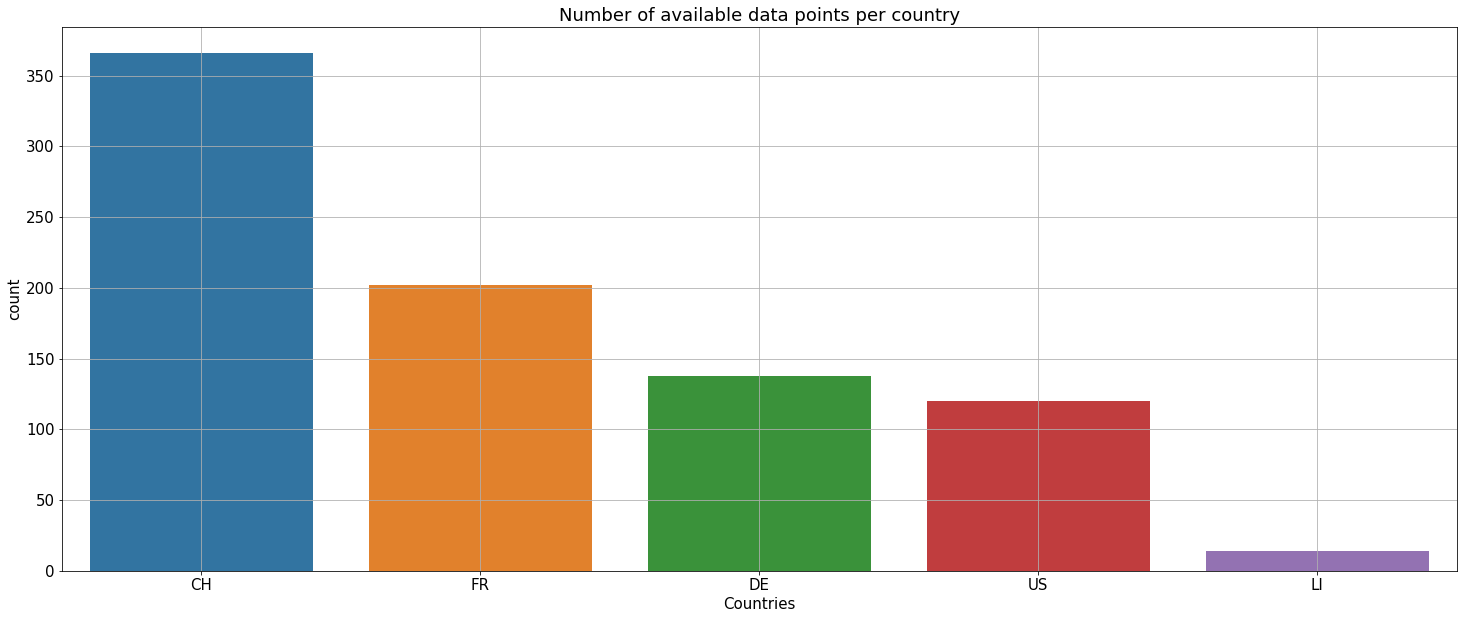

In [35]:
country_counts = pd.DataFrame(clients['country_id'].value_counts()).reset_index().rename(columns={'index':'country_id','country_id':'count'})


plt.subplots(figsize=(25, 10))

sns.barplot(x="country_id", y='count', data=country_counts)
plt.title('Number of available data points per country')
plt.grid()
plt.xlabel('Countries')
plt.ylabel('count')

***How does the distribution of the net income varies per country ?***

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.]),
 <a list of 7 Text xticklabel objects>)

<Figure size 2160x1800 with 0 Axes>

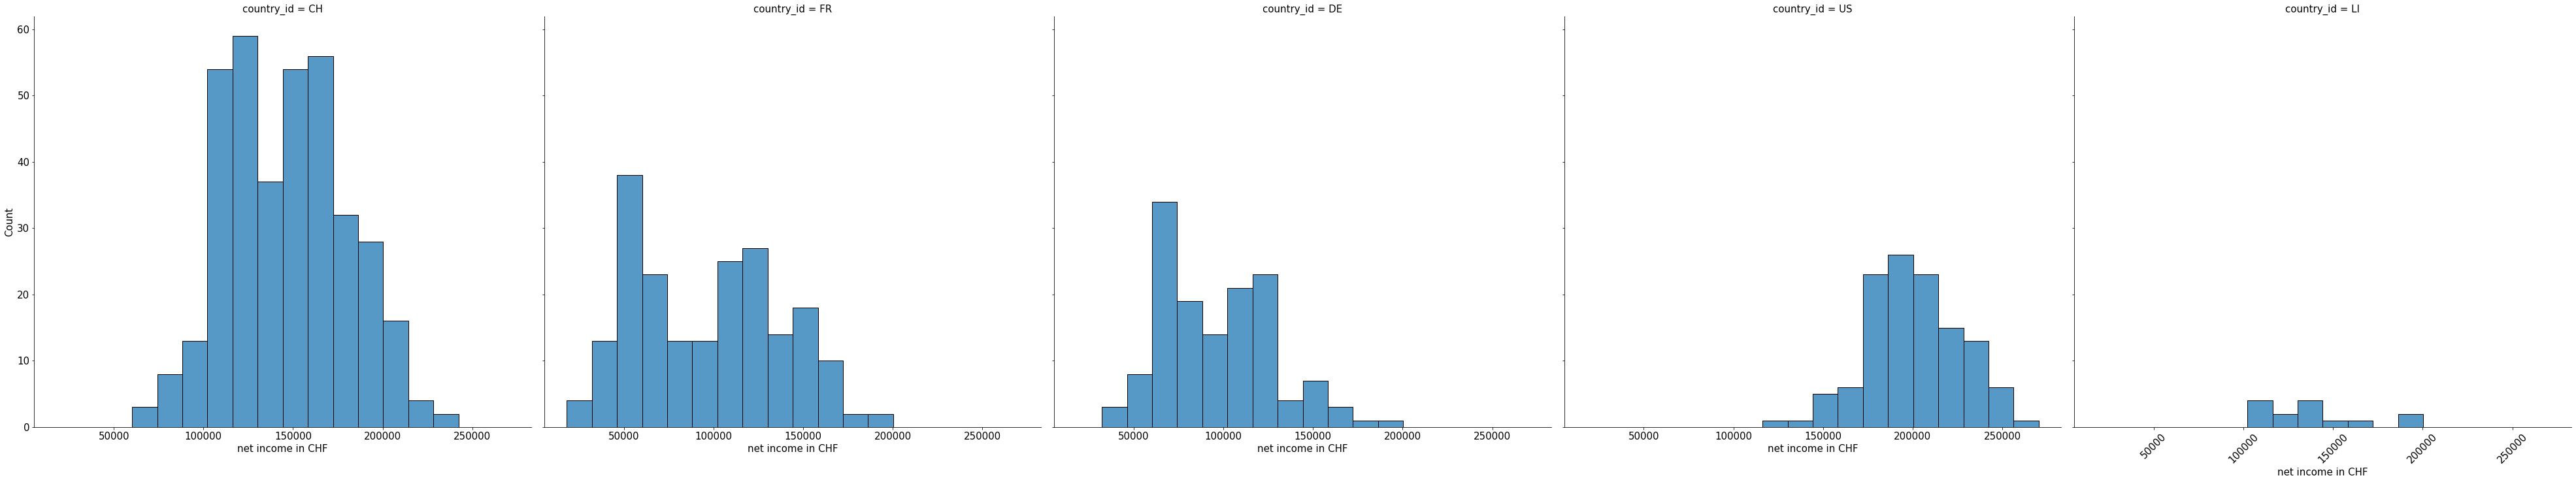

In [36]:
plt.figure(figsize=(30,25))

sns.displot(data=clients, x="net income in CHF", col='country_id', height = 10, aspect = 1.1)

plt.xticks(rotation=45)

***Is there any correlation between the age of the client and its net income profit ?***

Text(1454.9150000000002, 0.5, 'Client net income in CHF')

<Figure size 1440x720 with 0 Axes>

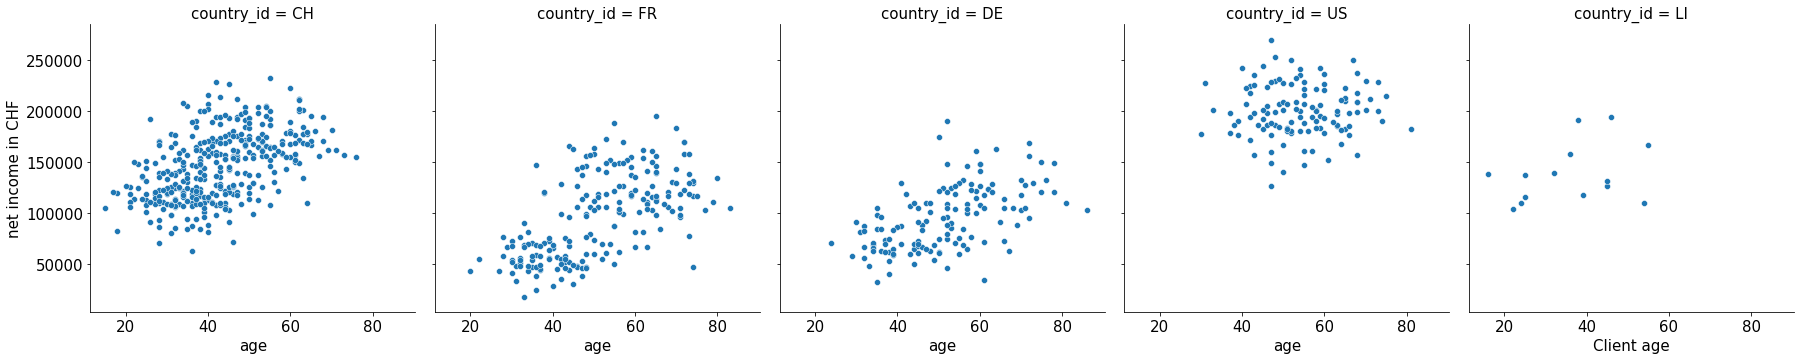

In [37]:
plt.figure(figsize=(20,10))

sns.relplot( data=clients, x="age", y="net income in CHF", col="country_id",kind="scatter")

#sns.scatterplot(data=clients, x ="age",y ="net income in CHF", hue='country')

plt.xlabel('Client age')
plt.ylabel('Client net income in CHF')

We see a positive linear dependancy between the age and the net income of client for all countries. The magnitude of the net income is different between a countries, an adjustment could be done by considering the main currency of each country.

### Assets & Issuers

In [38]:
assets.head(2)

,asset_id,isin,type,currency,issuer_id,name
0,000ee496-0c60-45a5-bde2-8dd430ef01bb,IE0254555353,Fund,EUR,25e72d39-6e28-4c07-a547-5e0d13bdeb99,Principal GI Fin Uncon EM Fx Inc I2 H EUR Acc
1,0014986b-cd0c-47ce-b110-d5d0af815f90,LU0806671914,Fund,USD,79293ec2-fef8-4785-b4c1-49f037ad0c8d,Galloway Emerging Markets High Yield Bd Fd C B U


***How many assets are there per type ?***

Text(0, 0.5, 'count')

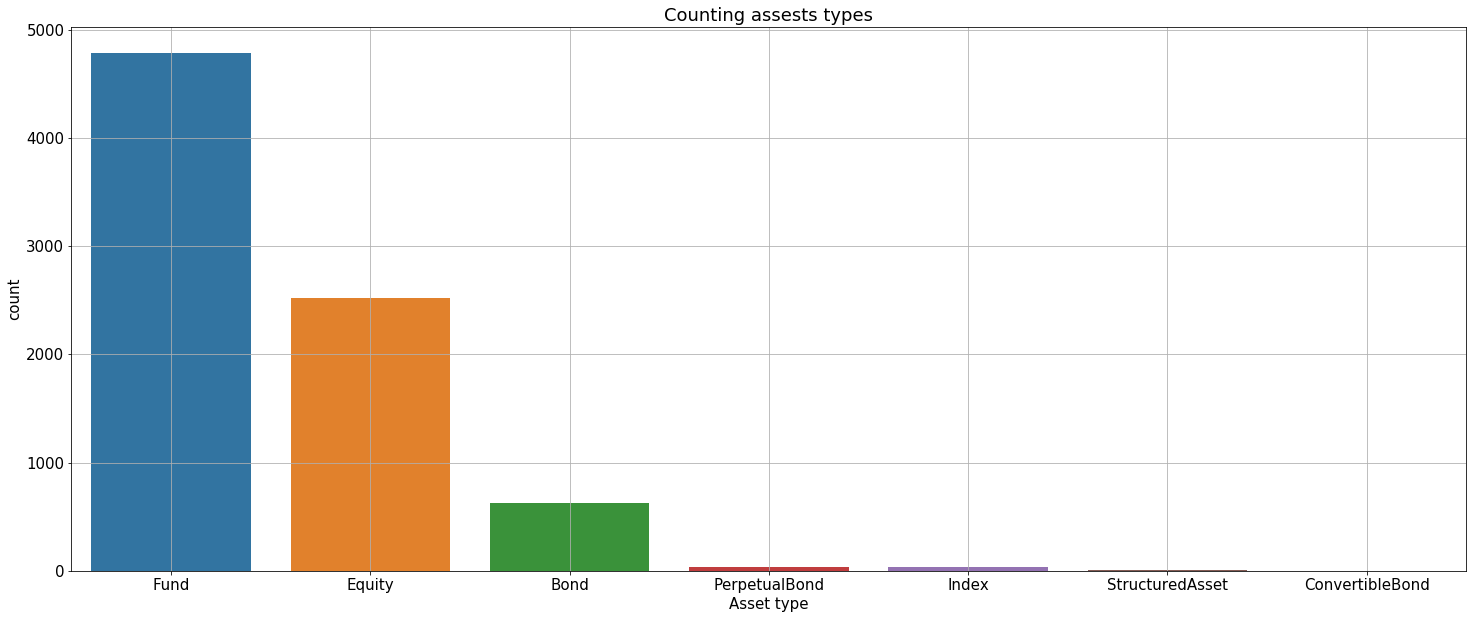

In [39]:
type_counts = pd.DataFrame(assets['type'].value_counts()).reset_index().rename(columns={'index':'type','type':'count'})

plt.subplots(figsize=(25, 10))

sns.barplot(x="type", y='count', data=type_counts)
plt.title('Counting assests types')
plt.grid()
plt.xlabel('Asset type')
plt.ylabel('count')

#### Merging Assets to issuers 
Here we combine the assets dataset to the issuers one to derive better insights. The merging will be based on the **issuer_id** column.  

In [40]:
assets_issuers = assets.merge(issuers_df, on = 'issuer_id', how='left')

In [41]:
assets_issuers.head(3)

,asset_id,isin,type,currency,issuer_id,name,issuer_name,country_id,sector_name,country_name,region_id
0,000ee496-0c60-45a5-bde2-8dd430ef01bb,IE0254555353,Fund,EUR,25e72d39-6e28-4c07-a547-5e0d13bdeb99,Principal GI Fin Uncon EM Fx Inc I2 H EUR Acc,Principal Gbl. Inv. Fds. - Finisterre Uncons. ...,IE,Miscellaneous,Ireland,Europe
1,0014986b-cd0c-47ce-b110-d5d0af815f90,LU0806671914,Fund,USD,79293ec2-fef8-4785-b4c1-49f037ad0c8d,Galloway Emerging Markets High Yield Bd Fd C B U,Galloway Feeder Fund - EM Hard Currency HY Bon...,LU,Miscellaneous,Luxembourg,Europe
2,0016a4f0-5879-42f2-bb5c-d7cb68a7134b,FR0008642917,Fund,EUR,786f5209-a567-4dcb-922f-6083c9a3ab01,Richelieu Family Small Cap R,Richelieu Family Small Cap,FR,Miscellaneous,France,Europe


***Counting the number of assets provided by each issuer:***

Text(0, 0.5, 'count')

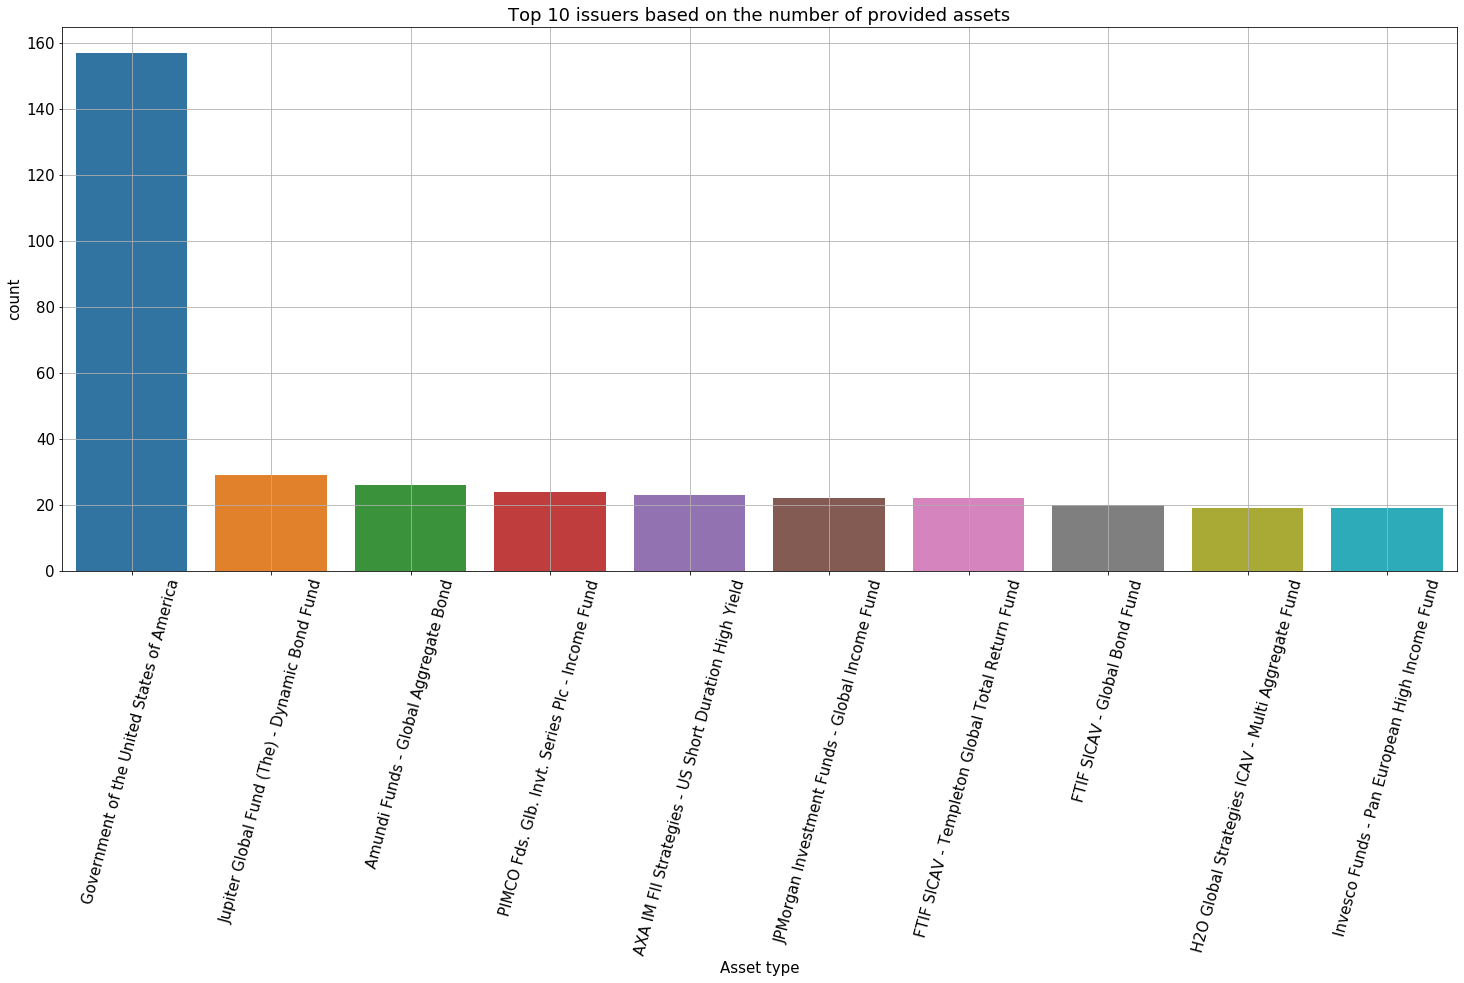

In [42]:
issuer_counts = pd.DataFrame(assets_issuers['issuer_name'].value_counts()).reset_index().rename(columns={'index':'issuer_name','issuer_name':'count'}).iloc[:10,:]

plt.subplots(figsize=(25, 10))

sns.barplot(x="issuer_name", y='count', data=issuer_counts)
plt.xticks(rotation=75) 

plt.title('Top 10 issuers based on the number of provided assets')
plt.grid()
plt.xlabel('Asset type')
plt.ylabel('count')

Counting assets per issuer's sectors : Since the asset id is not duplicated and we did a left join, we could simply count the values of sector name column

Text(0, 0.5, 'count')

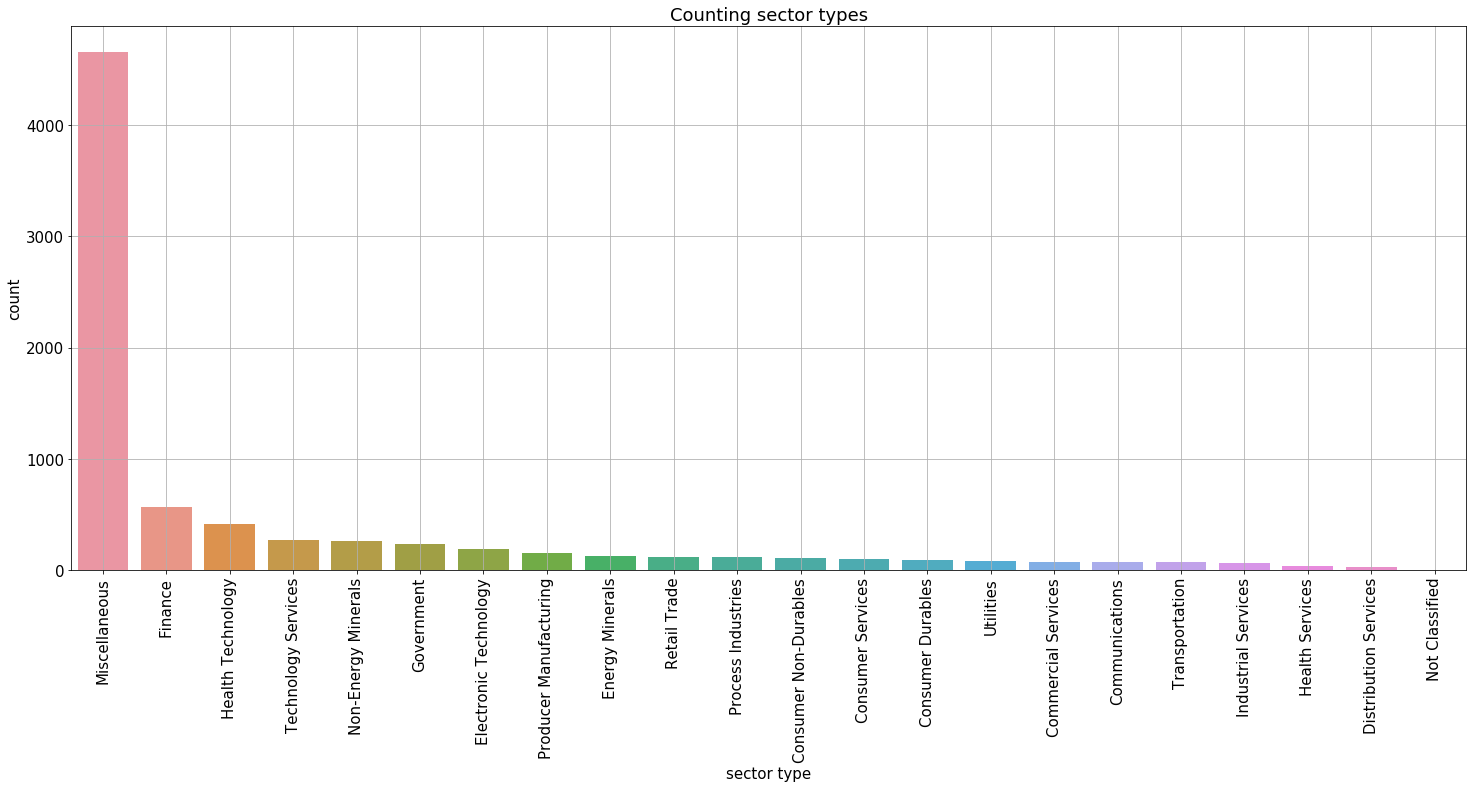

In [43]:
sector_counts = pd.DataFrame(assets_issuers['sector_name'].value_counts()).reset_index().rename(columns={'index':'sector_name','sector_name':'count'})


plt.subplots(figsize=(25, 10))

sns.barplot(x="sector_name", y='count', data=sector_counts)
plt.title('Counting sector types')
plt.xticks(rotation=90) 

plt.grid()
plt.xlabel('sector type')
plt.ylabel('count')

We see that the majority of the assets comes from issuers from Micellaneous sector

***Also it is important to verify the joint count between the asset type the the sector of the issuer***

Text(244.0, 0.5, 'Asset type')

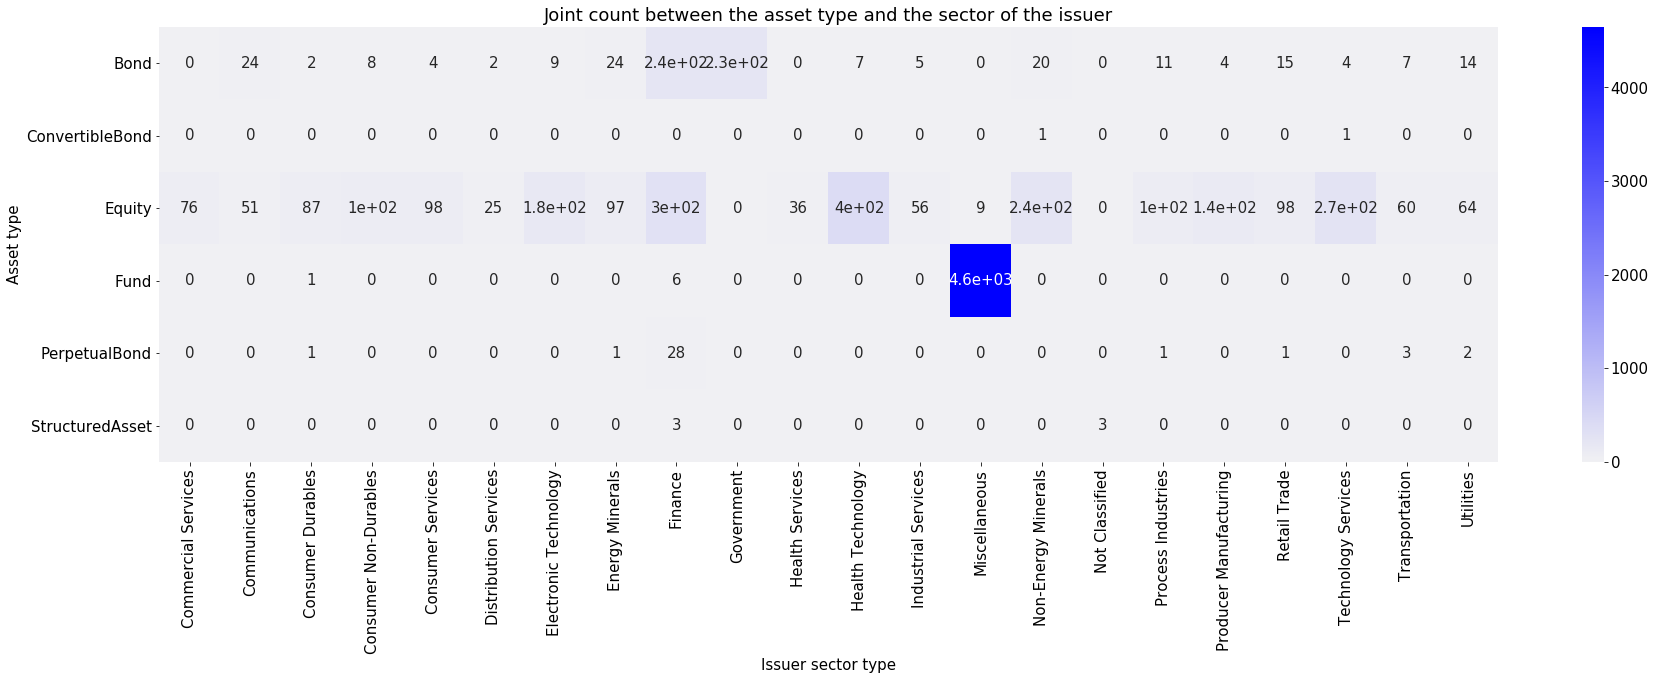

In [44]:
agg_columns = ['type','sector_name']
columns_to_keep =[ 'id', 'type','sector_name']

types_vs_sector = assets_issuers.groupby(agg_columns).agg('count')[['asset_id']].reset_index().rename(columns={'asset_id':'count'})


types_vs_sector_pivotted = pd.pivot_table(types_vs_sector, values='count', index=['type'],
                    columns=['sector_name'], aggfunc=np.sum)

types_vs_sector_pivotted.columns.name = None

types_vs_sector_pivotted = types_vs_sector_pivotted.fillna(0)


fig, ax = plt.subplots(figsize = (30,8))
sns.heatmap(types_vs_sector_pivotted, cmap=sns.color_palette("light:b", as_cmap=True), annot=True)

plt.title('Joint count between the asset type and the sector of the issuer')
 

plt.xlabel('Issuer sector type')
plt.ylabel('Asset type')



When dropping the Miscellaneous category we get :

Text(244.0, 0.5, 'asset type')

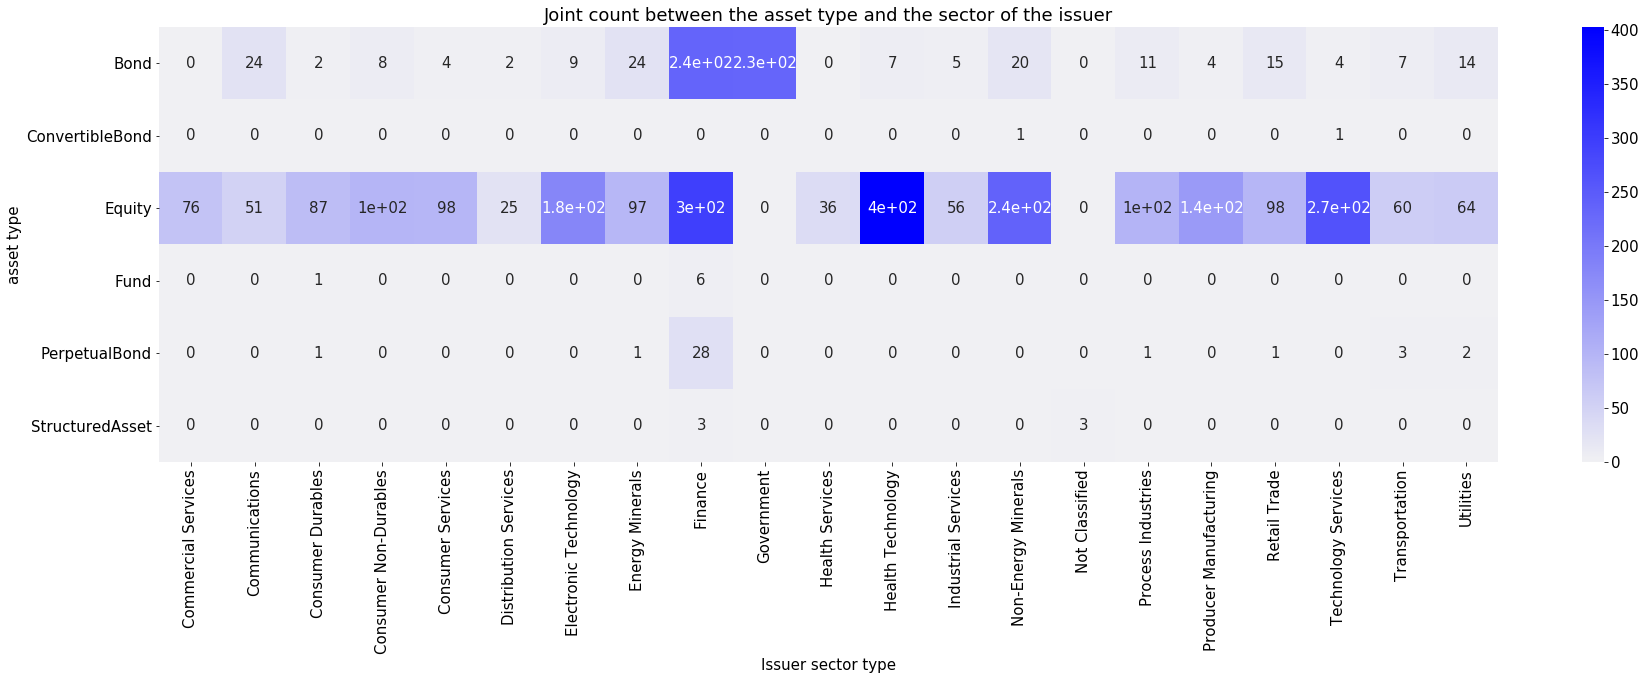

In [45]:
types_vs_sector_pivotted_ = types_vs_sector_pivotted.drop(['Miscellaneous'], axis=1)

fig, ax = plt.subplots(figsize = (30,8))


sns.heatmap(types_vs_sector_pivotted_, cmap=sns.color_palette("light:b", as_cmap=True), annot=True)

plt.title('Joint count between the asset type and the sector of the issuer')
 

plt.xlabel('Issuer sector type')
plt.ylabel('asset type')

When removing the Miscellaneous sector, we notice that the dataset contains a significant number of equities provided  by issuers from the healthcare and finance sectors.

### Preference Measures data

The distribution of the preference measure

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The mean score 0.8715917999267436
The median score 0.8636448926690423


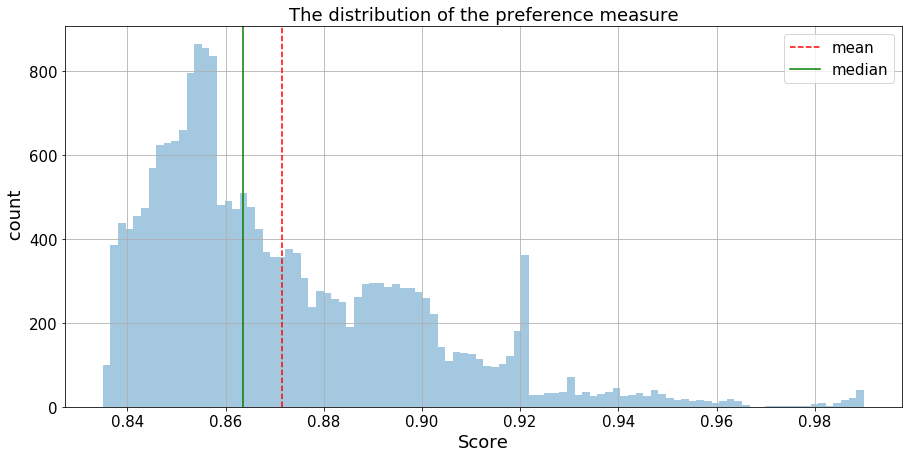

In [46]:
plt.figure(figsize=(15,7))
ax = sns.distplot(measures['score'], hist=True, kde=False, bins=100)
print('The mean score',measures['score'].mean())
print('The median score',measures['score'].median())
ax.axvline(measures['score'].mean(), color='r', linestyle='--', label='mean')
ax.axvline(measures['score'].median(), color='g', linestyle='-', label='median')
#ax.set_yscale('log')
plt.grid()
plt.xlabel('Score', size='large')
plt.ylabel(' count', size='large')
plt.title('The distribution of the preference measure')
plt.legend()
plt.show()

We observe that the range of the preference measure goes from approximatly 0.84 to 0.99

***Which asset has the highest average preference score ?***

In [47]:
columns_to_keep = ['asset_id','name','type','currency','issuer_name','sector_name','country_name',]

assets_issuer_ = assets_issuers[columns_to_keep]

measures_merged = measures.merge(assets_issuer_, on='asset_id',how='left')

measures_grouped = measures_merged.groupby(['asset_id','name','type']).agg('mean').sort_values(by = 'score', ascending=False).reset_index()


In [48]:
measures_merged.head(3)

,client_id,asset_id,score,name,type,currency,issuer_name,sector_name,country_name
0,306d09ec-eec2-f0d7-e303-990d17c17d51,cfbea06f-7eb2-4580-9556-e6a83f7bfd8a,0.921564,SPAIN GOVERNMENT OF 5.5 2017-07-30,Bond,EUR,Government of Spain,Government,Spain
1,306d09ec-eec2-f0d7-e303-990d17c17d51,23abcc26-40ef-4619-9792-5c49174c79cd,0.861499,AS SICAV I - Select Em Mkts Bond A Acc USD,Fund,USD,Aberdeen Std. SICAV I - Select Emerging Market...,Miscellaneous,Luxembourg
2,3fb6b173-07b2-5d4f-1879-7745243be968,5d23d1cc-d8bf-47da-927f-801c22bf7914,0.921587,Tarkett SA,Equity,EUR,Tarkett SA,Producer Manufacturing,France


Text(0, 0.5, 'Preference score')

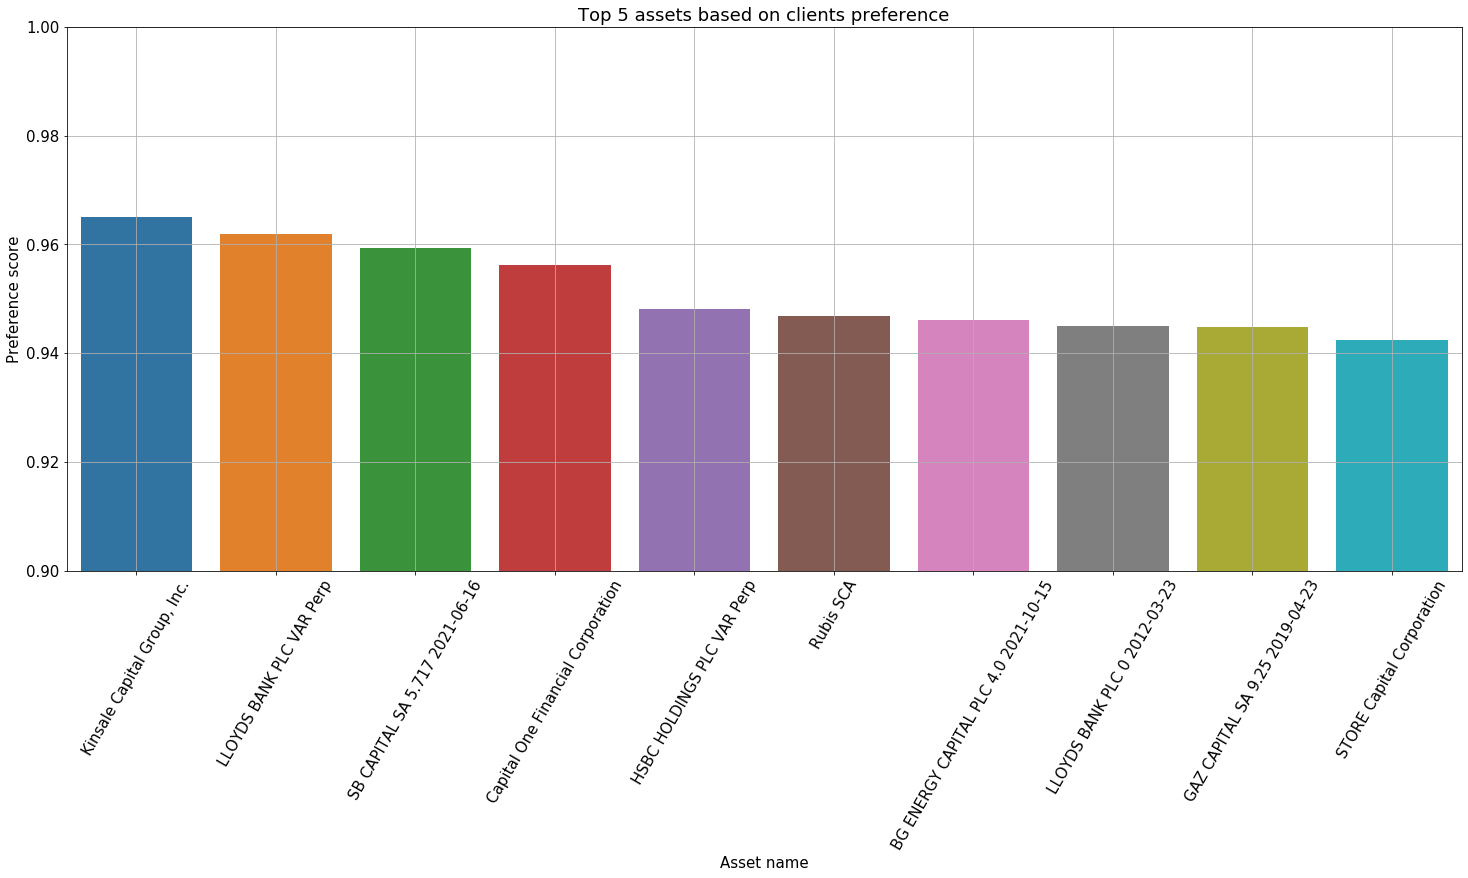

In [49]:
columns_to_keep = ['name', 'score']
data = measures_grouped[columns_to_keep].iloc[:10,:]
plt.subplots(figsize=(25, 10))

sns.barplot(x="name", y='score', data=data)
plt.ylim(0.9,1)

plt.xticks(rotation=60) 
plt.title('Top 5 assets based on clients preference')
plt.grid()
plt.xlabel('Asset name')
plt.ylabel('Preference score')

Here we used the average, we should consider the number of times an asset has been rated and include it in ranking of assets.

***What is the most prefered type of asset ?***

Text(0, 0.5, 'Preference score')

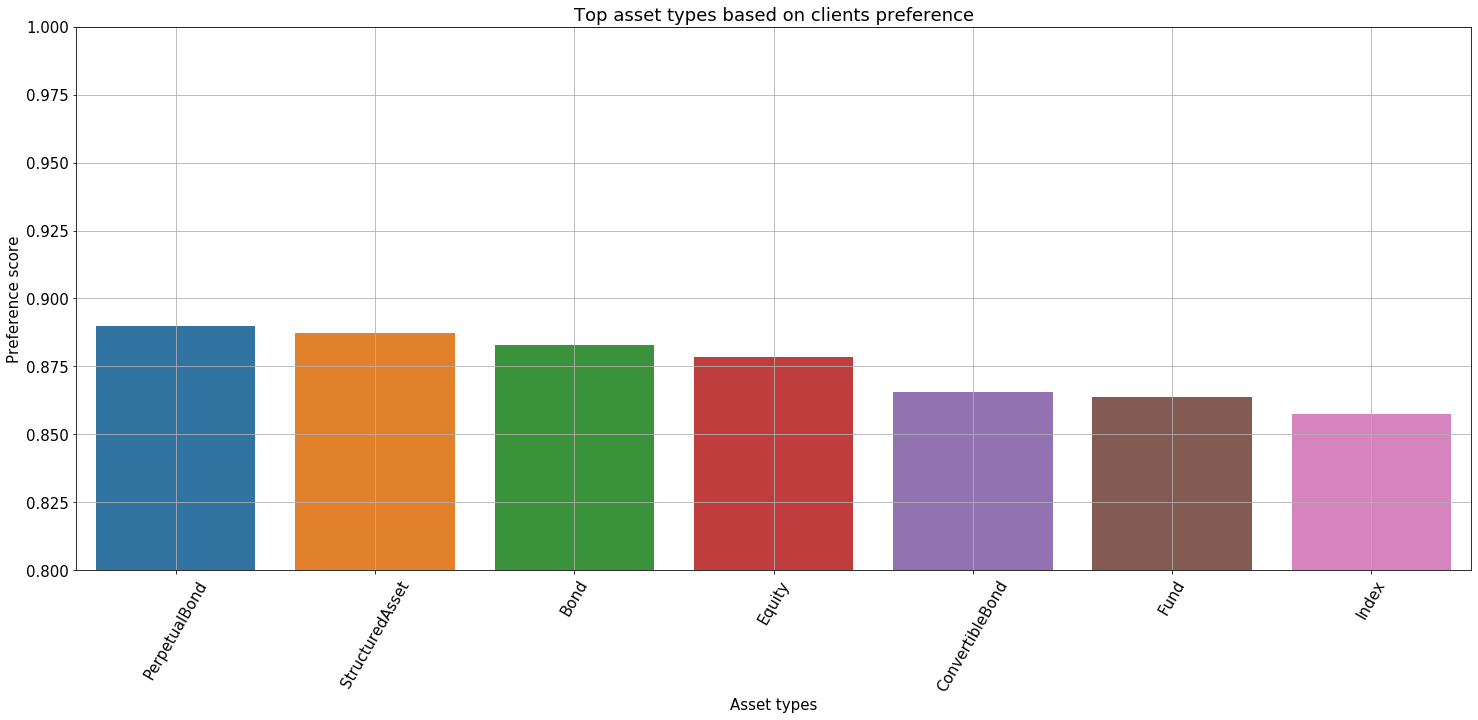

In [50]:
measures_grouped = measures_merged.groupby(['type']).agg('mean').sort_values(by = 'score', ascending=False).reset_index()

columns_to_keep = ['type', 'score']
data = measures_grouped[columns_to_keep]
plt.subplots(figsize=(25, 10))

sns.barplot(x="type", y='score', data=data)
plt.ylim(0.8,1)

plt.xticks(rotation=60) 
plt.title('Top asset types based on clients preference')
plt.grid()
plt.xlabel('Asset types')
plt.ylabel('Preference score')

***What is the most preffered assests based on the asset type and the sector type of the issuer ?***

Text(244.0, 0.5, 'asset type')

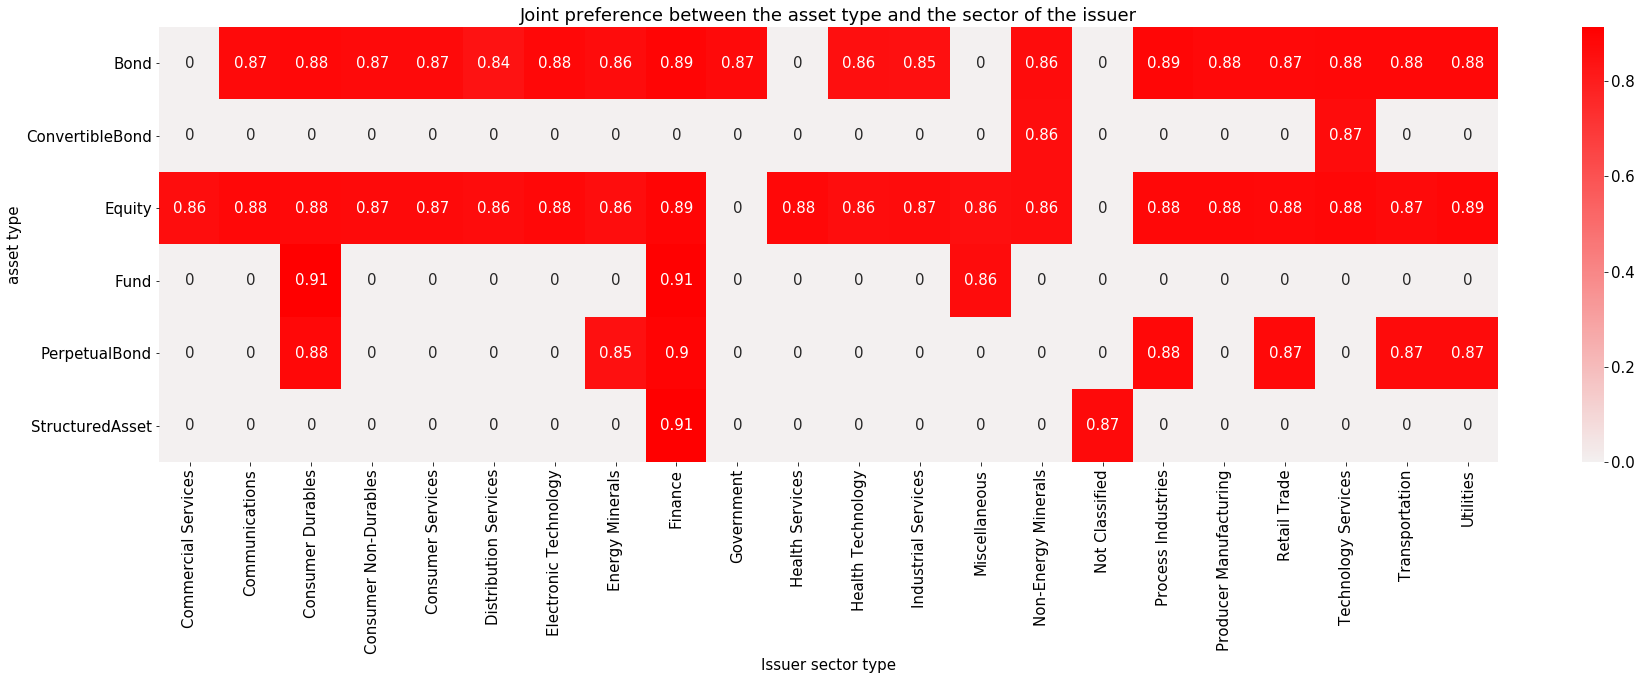

In [51]:
measures_grouped_2 = measures_merged.groupby(['type','sector_name']).agg('mean').sort_values(by = 'score', ascending=False).reset_index()

types_sector_vs_measures_pivotted = pd.pivot_table(measures_grouped_2, values='score', index=['type'],
                    columns=['sector_name'], aggfunc=np.sum)

types_sector_vs_measures_pivotted.columns.name = None

types_sector_vs_measures_pivotted = types_sector_vs_measures_pivotted.fillna(0)

fig, ax = plt.subplots(figsize = (30,8))
sns.heatmap(types_sector_vs_measures_pivotted, cmap=sns.color_palette("light:r", as_cmap=True), annot=True)

plt.title('Joint preference between the asset type and the sector of the issuer')
plt.xlabel('Issuer sector type')
plt.ylabel('asset type')


Notice that the highest average preference is reached for :

- Funds issued from a consumer durables sector = 0.91
- Funds issued from  Finance sector = 0.91
- Structured Assets issued from Finance sector = 0.91

***What assets does a client with a high net income prefer ?***

First, we start by grouping and aggregating clients operating indifferent countries

In [52]:
clients_grouped = clients.groupby(['client_id']).agg('sum').reset_index()[['client_id','net income in CHF']]

In [53]:
measures_with_income = measures_merged.merge(clients_grouped,on='client_id',how='left')

Text(289.0, 0.5, 'asset type')

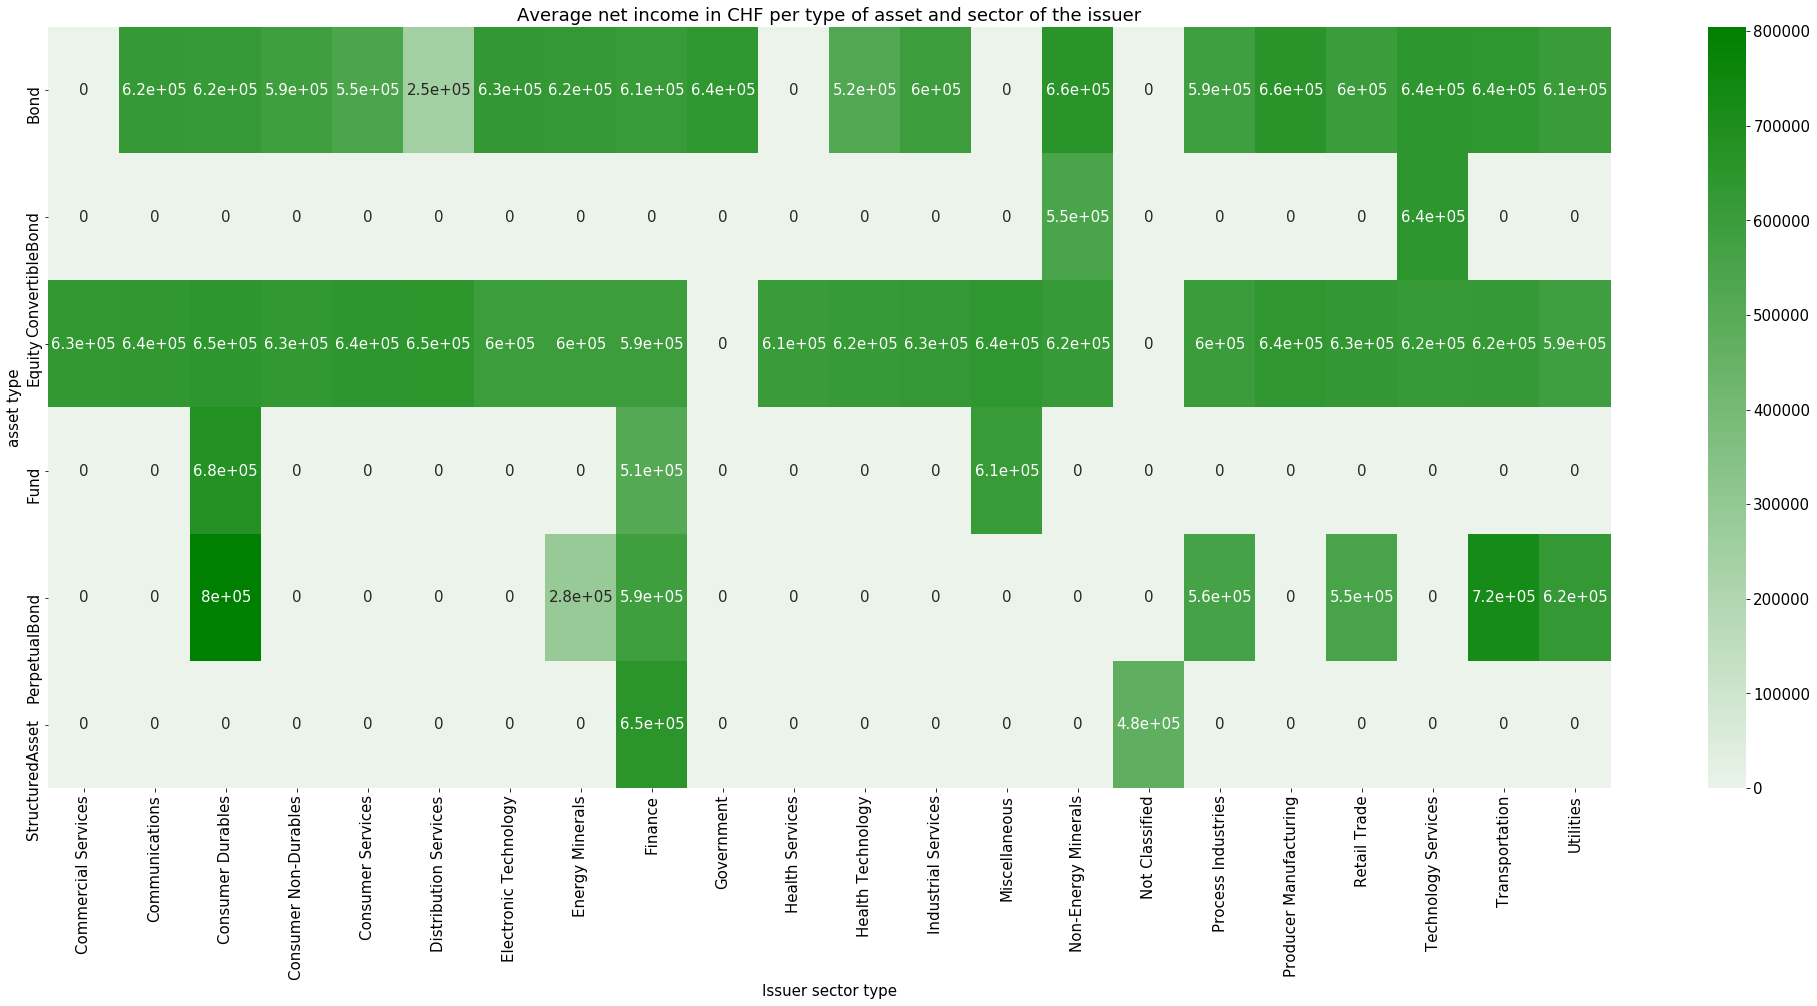

In [54]:
measures_grouped_3 = measures_with_income.groupby(['type','sector_name']).agg('mean').sort_values(by = 'net income in CHF', ascending=False)[['net income in CHF']].reset_index()

types_sector_vs_income_pivotted = pd.pivot_table(measures_grouped_3, values='net income in CHF', index=['type'],
                    columns=['sector_name'], aggfunc=np.sum)

types_sector_vs_income_pivotted.columns.name = None

types_sector_vs_income_pivotted = types_sector_vs_income_pivotted.fillna(0)

fig, ax = plt.subplots(figsize = (35,14))
sns.heatmap(types_sector_vs_income_pivotted, cmap=sns.color_palette("light:g", as_cmap=True), annot=True)

plt.title('Average net income in CHF per type of asset and sector of the issuer')
plt.xlabel('Issuer sector type')
plt.ylabel('asset type')


We observe that clients with average net income equal to 800000 CHF are investing in perpetual bonds issued from consumer durable sector.

# Part III : Predictive tasks

Here are the features we want to develop:

- We would like to predict the currency of an asset, given its name and its ISIN.

- We would like to predict the type of an asset, given its name, its issuer’s name, it’s issuer’s sector and it’s currency.

- We would like to discover categories of client depending on their characteristics and preferences.

- We would like to predict the level of preference a client could have for an instrument. The fact that a product is not owned does not necessary means that the client has a low preference for it.

## 1)  Predicting the currency of an asset given its name and its ISIN

In [55]:
columns_to_keep = ['name','isin','currency']

assets_subset = assets[columns_to_keep]

print('The currencies are ', assets_subset.currency.unique())

## Getting all currencies

currencies = assets_subset.currency.unique()

assets_subset.head(5)



The currencies are  ['EUR' 'USD' 'CAD' 'GBP' 'NOK' 'CHF' 'CNY' 'AUD' 'BRL' 'SGD' 'KRW' 'JPY'
 'HKD' 'XXX' 'ZAR' 'SEK' 'IDR' 'MXN' 'EGP' 'AED' 'PLN' 'NZD' 'CNH' 'PHP'
 'RUB' 'THB' 'TRY' 'ILS' 'TWD' 'DKK']


,name,isin,currency
0,Principal GI Fin Uncon EM Fx Inc I2 H EUR Acc,IE0254555353,EUR
1,Galloway Emerging Markets High Yield Bd Fd C B U,LU0806671914,USD
2,Richelieu Family Small Cap R,FR0008642917,EUR
3,Amundi Funds II U.S. Pioneer Fund A No Dis EUR,LU0123305356,EUR
4,Schroder ISF Glo Climate Change Eq EUR Hdg A Acc,LU1014650443,EUR


We see that the some assets names contain the currency : *Principal GI Fin Uncon EM Fx Inc I2 H EUR Acc, Amundi Funds II U.S. Pioneer Fund A No Dis EUR*
    
Also, the first two characters of the isin are country indicators in which the issuing company is headquartered : *IE0254555353 ---> IE* 

***Model 1 : Base Model*** : To predict the currency from the name and the isin, we will first extract the country Id of the issuer from the isin then we will check if any currency is mentionned in the name. The model is simply as follows:

If the currency is mentionned we will consider it as our predictive value, otherwise we will use the mostly used currency in the country of the issuer. 



***Model 2 : Random Forest Classifier*** : We will create dummy variables for categorical features : *issuer country* and the extracted *currency from the name*. Then we will fit a random forest model. 

***Extracting needed features***

Let us extract the country id from the isin:

In [56]:
assets_subset['currency_from_name'] = assets_subset['name'].apply(lambda x: extract_value_from_name(x,currencies))

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
assets_subset['issuer_country_id'] = assets_subset['isin'].apply(lambda x : x[0:2])

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
assets_subset_ = assets_subset[['currency','currency_from_name','issuer_country_id']]

In [59]:
assets_subset_.head(4)

,currency,currency_from_name,issuer_country_id
0,EUR,EUR,IE
1,USD,na,LU
2,EUR,na,FR
3,EUR,EUR,LU


***Model 1: Base Model***

In [60]:
### Shuffling dataset
assets_subset_shuffled = shuffle(assets_subset_)

### Splitting dataset
n_training = 6000
training_data = assets_subset_shuffled.iloc[:n_training,:]
testing_data = assets_subset_shuffled.iloc[n_training:,:]

### Getting the most used currency per country
issuer_data = training_data.groupby(['issuer_country_id', 'currency']).agg('count').sort_values('currency_from_name',ascending=False).reset_index()

### Getting the most used currency per issuer country
highest_currency = issuer_data.drop_duplicates('issuer_country_id')

country_currency_mapping = {}
for index, row in highest_currency.iterrows():
    country_currency_mapping[row['issuer_country_id']] = row['currency']


In [61]:
def currency_predictor(currency_from_name, issuer_country):
    
    if currency_from_name != 'na':
        
        return currency_from_name
    
    if issuer_country in list(country_currency_mapping.keys()):
        return country_currency_mapping[issuer_country]
    
    else:
        return 'USD'
                

In [62]:
### Predicting on training set
training_data['predicted_currency'] = training_data.apply(lambda x: currency_predictor(x['currency_from_name'],x['issuer_country_id']), axis=1)

### Predicting on testing set

testing_data['predicted_currency'] = testing_data.apply(lambda x: currency_predictor(x['currency_from_name'],x['issuer_country_id']), axis=1)

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


***Evaluating the model***

In [63]:
### Training accuracy
n_train = len(training_data)
matched = len(training_data[training_data.currency == training_data['predicted_currency'] ])
print('Training Accuracy : ', (matched/n_train)*100)


### Testing accuracy
n_test = len(testing_data)
matched = len(testing_data[testing_data.currency == testing_data['predicted_currency'] ])
print('Testing Accuracy : ', (matched/n_test)*100)

Training Accuracy :  89.86666666666666
Testing Accuracy :  90.65141720537046


***Cheking misclassified points***

In [64]:
testing_data[testing_data.currency != testing_data['predicted_currency'] ].head(6)

,currency,currency_from_name,issuer_country_id,predicted_currency
14,AUD,na,LU,EUR
15,GBP,na,LU,EUR
10,GBP,na,LU,EUR
19,EUR,na,CH,CHF
30,USD,na,LU,EUR
38,USD,na,LU,EUR


***Comments*** :  

- This model could be enhanced by using stratified k-fold cross validaion where we ensure the existance of all countries in the training set with the same proportions as in the main sample. 

- Also, we have assigned to each issuer country the most used currency in a deterministic manner, One can enhance the model by considering a probabilistic approch where currencies are drown based on a probability distribution. 

***Model 2 : Random forest model***

In [65]:
## Separating feaatures from label
X = assets_subset_[['currency_from_name','issuer_country_id']]

## creating dummy variables from categorical features 

X_dummies = pd.get_dummies(X)

## transforming type to ordinal values
ord_enc = OrdinalEncoder()
assets_subset_["label"] = ord_enc.fit_transform(assets_subset_['currency'].values.reshape(-1, 1))

y = assets_subset_['label']

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [66]:
X_dummies.head(2)

,currency_from_name_AUD,currency_from_name_CAD,currency_from_name_CHF,currency_from_name_EUR,currency_from_name_GBP,currency_from_name_HKD,currency_from_name_ILS,currency_from_name_JPY,currency_from_name_NOK,currency_from_name_NZD,...,issuer_country_id_SG,issuer_country_id_TH,issuer_country_id_TW,issuer_country_id_US,issuer_country_id_VG,issuer_country_id_XC,issuer_country_id_XD,issuer_country_id_XS,issuer_country_id_ZA,issuer_country_id_ZM
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
### Splitting training and testing
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.20, random_state=42)

***Setting the model***

In [68]:
Criterion = 'gini'
clf = RandomForestClassifier(max_depth=10, random_state=0,criterion=Criterion)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

In [69]:
n_correctly_classified  = (y_hat == y_train).value_counts()[True] 
n = len(y_hat)
train_accuracy = (n_correctly_classified/n)*100
print('Training accuracy :', train_accuracy)

Training accuracy : 88.48314606741573


In [70]:
n_correctly_classified  = (y_test_hat == y_test).value_counts()[True] 
n = len(y_test_hat)
test_accuracy = (n_correctly_classified/n)*100
print('Testing accuracy :', test_accuracy)

Testing accuracy : 88.64628820960698


***Comments*** 

- The performance of the tree based model is more or less the same as the baseline model. One could check the impact of increasing model complexity by augmenting the number of trees or incresing the tree depth parameter

## 2)  Predicting the type of an asset given its name, its issuer’s name, it’s issuer’s sector and it’s currency.




To predict the type of an asset, we will extract from the name of the aaset any word realtes to type. Next we will create dummy variables for all categorical features *issuer name, issuer sector, currency and the extracted type if it exists*

***Extracting features***

In [71]:
columns_to_keep = ['name','currency','type','issuer_name','sector_name']

assets_issuers_subset = assets_issuers[columns_to_keep]

assets_issuers_subset.tail(3)

,name,currency,type,issuer_name,sector_name
8008,Agripower France SASU,EUR,Equity,AGRIPOWER France,Utilities
8009,Amundi Oblig Internationales EUR P (C),EUR,Fund,Amundi Oblig Internationales,Miscellaneous
8010,Schneider Electric SE,EUR,Equity,Schneider Electric SE,Producer Manufacturing


In [72]:
assets_issuers_subset.type.unique()

array(['Fund', 'Equity', 'Bond', 'PerpetualBond', 'Index',
       'StructuredAsset', 'ConvertibleBond'], dtype=object)

In [73]:
assets_issuers_subset[assets_issuers_subset.type=='Equity'].head(5)

,name,currency,type,issuer_name,sector_name
8,Gold Standard Ventures Corp.,CAD,Equity,Gold Standard Ventures Corp.,Non-Energy Minerals
9,"YETI Holdings, Inc.",USD,Equity,"YETI Holdings, Inc.",Producer Manufacturing
13,Revelo Resources Corp,CAD,Equity,Revelo Resources Corp.,Non-Energy Minerals
15,Seadrill Ltd.,NOK,Equity,Seadrill Ltd.,Industrial Services
17,QuantumScape Corporation Class A,USD,Equity,QuantumScape Corp.,Producer Manufacturing


In [74]:
### List of all asset types

asset_types = [x.upper() for x in assets_issuers_subset.type.unique()]

### Extracting from asset name
assets_issuers_subset['type_from_name'] = assets_issuers_subset['name'].apply(lambda x: extract_value_from_name(x,asset_types))

### Extracting from issuer name
assets_issuers_subset['type_from_issuer_name'] = assets_issuers_subset['issuer_name'].apply(lambda x: extract_value_from_name(x,asset_types))


/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [75]:
assets_issuers_subset.type_from_name.value_counts()

na        6789
BOND       442
FUND       386
EQUITY     326
INDEX       68
Name: type_from_name, dtype: int64

In [76]:
assets_issuers_subset.type_from_issuer_name.value_counts()

na        5599
FUND      1907
BOND       252
EQUITY     216
INDEX       37
Name: type_from_issuer_name, dtype: int64

***Creating dummy variables for each categorical variable***

In [77]:
## Separating feaatures from label
X = assets_issuers_subset[['currency','sector_name','type_from_issuer_name','type_from_name']]

## creating dummy variables from categorical features 

X_dummies = pd.get_dummies(X)

## transforming type to ordinal values
ord_enc = OrdinalEncoder()
assets_issuers_subset["label"] = ord_enc.fit_transform(assets_issuers_subset['type'].values.reshape(-1, 1))
assets_issuers_subset[["type", "label"]]

y = assets_issuers_subset['label']



/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


***10-folds cross_validation***

***Using random forest classifier***

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


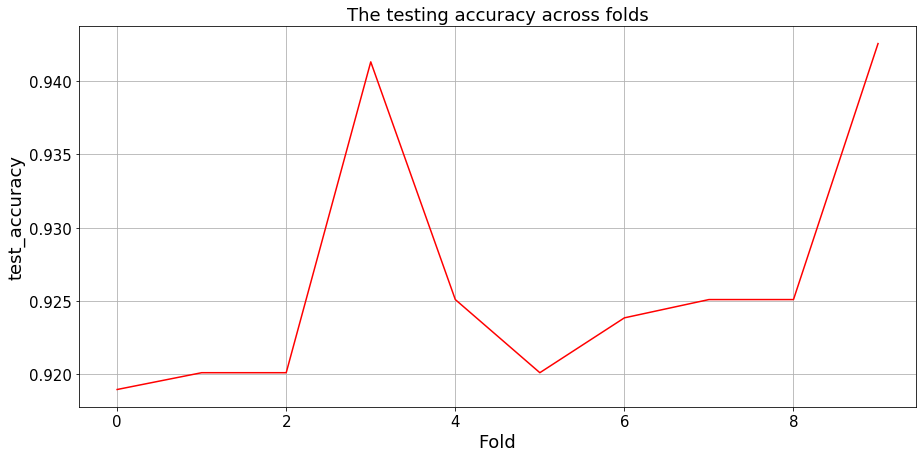

In [78]:
from sklearn.model_selection import cross_validate
clf = RandomForestClassifier(max_depth=7, random_state=0)
scoring = ['accuracy']
scores = cross_validate(clf, X_dummies, y, cv=10, scoring=scoring)
test_accuracy = scores['test_accuracy']

fig = plt.figure(figsize=(15,7))
plt.plot(test_accuracy,color='r')
plt.grid()
plt.ylabel("test_accuracy", size="large")
plt.xlabel("Fold", size="large")

plt.title("The testing accuracy across folds", size="large")
plt.show();


***Prediction using one train-test split***

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.20, random_state=42)

In [80]:
clf.fit(X_train, y_train)
y_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

In [81]:
n_correctly_classified  = (y_hat == y_train).value_counts()[True] 
n = len(y_hat)
train_accuracy = (n_correctly_classified/n)*100
print('training accuracy :', train_accuracy)

training accuracy : 92.7434456928839


In [82]:
n_correctly_classified  = (y_test_hat == y_test).value_counts()[True] 
n = len(y_test_hat)
test_accuracy = (n_correctly_classified/n)*100
print('Testing accuracy :', test_accuracy)

Testing accuracy : 93.07548346849657


## 3) Discover categories of client depending on their characteristics and preferences.



***Clients net income per country***

Some clients are operating in different countries. Thus we will create a set of feature reflecting the net income per country. To do that we will pivot the clients table to get a format where each client is presented by a single row. 

The new features are the net income per country and the age per country.


Since we will cluster clients, we will present each client as follows:

- Net income per country
- Age per country
- Average score per Issurer region
- Creating a new feature combining the asset type and the issuer sector and computing the average score per features


After getting all the features we will project the data points in the principal component space and explore visually grouping patterns. 

A second method will consist in inspecting the number of possible clusters using the dendogram and use algomerative clustring.

At the end, we will analyze feature separability across clusters.

In [83]:
clients.head(2)

,client_id,age,net income in CHF,country_id
0,2076663f-998b-201b-cb18-af7d314fa4fb,62,172198.128533,CH
1,a8ac18ac-deff-1ac7-0962-bb0188525840,55,108586.151459,CH


In [84]:
clients_net_income_pivotted = pd.pivot_table(clients, values='net income in CHF', index=['client_id'],
                    columns=['country_id'], aggfunc=np.sum)

clients_net_income_pivotted.columns.name = None

clients_net_income_pivotted = clients_net_income_pivotted.fillna(0)

clients_net_income_pivotted = clients_net_income_pivotted.rename(columns = {'CH':'CH_net','DE':'DE_net','FR':'FR_net','LI':'LI_net','US':'US_net'}).reset_index()

clients_net_income_pivotted.head(4)

,client_id,CH_net,DE_net,FR_net,LI_net,US_net
0,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.000000,143423.245659,0.000000,223423.245659
1,04c5a4f0-cf49-5660-0693-6fc0c89b392c,0.000000,0.000000,105802.409183,268703.613774,0.000000
2,062f7012-be7a-1a07-5468-1ee06113ae7c,304284.313876,204284.313876,59761.437959,0.000000,209522.875917
3,069ab95d-6e30-dbcf-e6c8-14e804c1cb81,237356.498607,0.000000,84904.332405,0.000000,0.000000


***Clients age per country***

In [85]:
clients_age_pivotted = pd.pivot_table(clients, values='age', index=['client_id'],
                    columns=['country_id'], aggfunc=np.sum)

clients_age_pivotted.columns.name = None

clients_age_pivotted = clients_age_pivotted.fillna(0)

clients_age_pivotted = clients_age_pivotted.rename(columns = {'CH':'CH_age','DE':'DE_age','FR':'FR_age','LI':'LI_age','US':'US_age'}).reset_index()

clients_age_pivotted.head(4)

,client_id,CH_age,DE_age,FR_age,LI_age,US_age
0,002f6006-d9f7-4cfb-4208-fa83274c325a,103.0,0.0,70.0,0.0,65.0
1,04c5a4f0-cf49-5660-0693-6fc0c89b392c,0.0,0.0,46.0,60.0,0.0
2,062f7012-be7a-1a07-5468-1ee06113ae7c,108.0,125.0,50.0,0.0,68.0
3,069ab95d-6e30-dbcf-e6c8-14e804c1cb81,95.0,0.0,66.0,0.0,0.0


***Merging age data to income data***

In [86]:
clients_pivotted = clients_net_income_pivotted.merge(clients_age_pivotted,on='client_id', how='left')

In [87]:
clients_pivotted.head(2)

,client_id,CH_net,DE_net,FR_net,LI_net,US_net,CH_age,DE_age,FR_age,LI_age,US_age
0,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.0,143423.245659,0.000000,223423.245659,103.0,0.0,70.0,0.0,65.0
1,04c5a4f0-cf49-5660-0693-6fc0c89b392c,0.000000,0.0,105802.409183,268703.613774,0.000000,0.0,0.0,46.0,60.0,0.0


***Getting preference features***

In [88]:
preference_asset_issuer = measures.merge(assets_issuers, on = 'asset_id', how='left')

preference_asset_issuer = preference_asset_issuer.rename(columns = {'country_id':'issuer_country_id'}).drop(['asset_id','isin','issuer_id','country_name'], axis=1)

In [89]:
preference_asset_issuer.head(3)

,client_id,score,type,currency,name,issuer_name,issuer_country_id,sector_name,region_id
0,306d09ec-eec2-f0d7-e303-990d17c17d51,0.921564,Bond,EUR,SPAIN GOVERNMENT OF 5.5 2017-07-30,Government of Spain,ES,Government,Europe
1,306d09ec-eec2-f0d7-e303-990d17c17d51,0.861499,Fund,USD,AS SICAV I - Select Em Mkts Bond A Acc USD,Aberdeen Std. SICAV I - Select Emerging Market...,LU,Miscellaneous,Europe
2,3fb6b173-07b2-5d4f-1879-7745243be968,0.921587,Equity,EUR,Tarkett SA,Tarkett SA,FR,Producer Manufacturing,Europe


In [90]:
clients_preference_asset_issuer_grouped = preference_asset_issuer.groupby(['client_id','type',
                                                                                   'sector_name','region_id']).agg('mean')['score'].reset_index()
clients_preference_asset_issuer_grouped.head(3)

,client_id,type,sector_name,region_id,score
0,002f6006-d9f7-4cfb-4208-fa83274c325a,Bond,Energy Minerals,Latin America,0.852103
1,002f6006-d9f7-4cfb-4208-fa83274c325a,Bond,Finance,Europe,0.945593
2,002f6006-d9f7-4cfb-4208-fa83274c325a,Bond,Finance,North America,0.864268


In [91]:
clients_preference_asset_issuer_grouped['type_sector'] = clients_preference_asset_issuer_grouped.apply(lambda x: x.type+'-'+x.sector_name, axis=1)

clients_preference_asset_issuer_grouped = clients_preference_asset_issuer_grouped.drop(['type','sector_name'], axis=1)

In [92]:
## Getting average score per asset type and issuer sector

clients_score_type_sector = pd.pivot_table(clients_preference_asset_issuer_grouped, values='score', index=['client_id'],
                    columns=['type_sector'], aggfunc=np.mean)

clients_score_type_sector.columns.name = None

clients_score_type_sector = clients_score_type_sector.fillna(0).reset_index()


## Getting average score per issuer region id

clients_score_region = pd.pivot_table(clients_preference_asset_issuer_grouped, values='score', index=['client_id'],
                    columns=['region_id'], aggfunc=np.mean)

clients_score_region.columns.name = None

clients_score_region = clients_score_region.fillna(0).reset_index()



In [93]:
clients_score_type_sector.head(2)

,client_id,Bond-Communications,Bond-Consumer Durables,Bond-Consumer Non-Durables,Bond-Consumer Services,Bond-Distribution Services,Bond-Electronic Technology,Bond-Energy Minerals,Bond-Finance,Bond-Government,...,Fund-Miscellaneous,PerpetualBond-Consumer Durables,PerpetualBond-Energy Minerals,PerpetualBond-Finance,PerpetualBond-Process Industries,PerpetualBond-Retail Trade,PerpetualBond-Transportation,PerpetualBond-Utilities,StructuredAsset-Finance,StructuredAsset-Not Classified
0,002f6006-d9f7-4cfb-4208-fa83274c325a,0.0,0.0,0.0,0.0,0.0,0.0,0.852103,0.904930,0.874601,...,0.879602,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,04c5a4f0-cf49-5660-0693-6fc0c89b392c,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.850133,0.871186,...,0.857146,0.0,0.0,0.0,0.862403,0.0,0.0,0.0,0.0,0.0


In [94]:
clients_score_type_sector.head(2)

,client_id,Bond-Communications,Bond-Consumer Durables,Bond-Consumer Non-Durables,Bond-Consumer Services,Bond-Distribution Services,Bond-Electronic Technology,Bond-Energy Minerals,Bond-Finance,Bond-Government,...,Fund-Miscellaneous,PerpetualBond-Consumer Durables,PerpetualBond-Energy Minerals,PerpetualBond-Finance,PerpetualBond-Process Industries,PerpetualBond-Retail Trade,PerpetualBond-Transportation,PerpetualBond-Utilities,StructuredAsset-Finance,StructuredAsset-Not Classified
0,002f6006-d9f7-4cfb-4208-fa83274c325a,0.0,0.0,0.0,0.0,0.0,0.0,0.852103,0.904930,0.874601,...,0.879602,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,04c5a4f0-cf49-5660-0693-6fc0c89b392c,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.850133,0.871186,...,0.857146,0.0,0.0,0.0,0.862403,0.0,0.0,0.0,0.0,0.0


***Putting all the features together***

In [95]:
clients_scores_pivotted = clients_pivotted.merge(clients_score_type_sector,on='client_id',how='left')

clients_scores_pivotted = clients_scores_pivotted.merge(clients_score_region,on='client_id',how='left')

clients_features = clients_scores_pivotted.drop(['N/A'],axis=1)

In [96]:
clients_features.head(2)

,client_id,CH_net,DE_net,FR_net,LI_net,US_net,CH_age,DE_age,FR_age,LI_age,...,PerpetualBond-Utilities,StructuredAsset-Finance,StructuredAsset-Not Classified,Africa,Asia,Europe,Latin America,Middle East,North America,Pacific
0,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.0,143423.245659,0.000000,223423.245659,103.0,0.0,70.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.895574,0.852103,0.890615,0.881911,0.0
1,04c5a4f0-cf49-5660-0693-6fc0c89b392c,0.000000,0.0,105802.409183,268703.613774,0.000000,0.0,0.0,46.0,60.0,...,0.0,0.0,0.0,0.0,0.860617,0.873605,0.862403,0.000000,0.876255,0.0


***Principal component analysis***

In this part we will project the client representation built above into a three dimensional principal component space. Next, we will inspect visually the projected points to see if there is any significant grouping based on the variance.

***SCALING*** : Since we are inspecting the variance, we will not scale the values in this part.

In [97]:
pca = PCA(n_components=3)

pca_data= clients_scores_pivotted.drop(['client_id'],axis=1)
principalComponents = pca.fit_transform(pca_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])


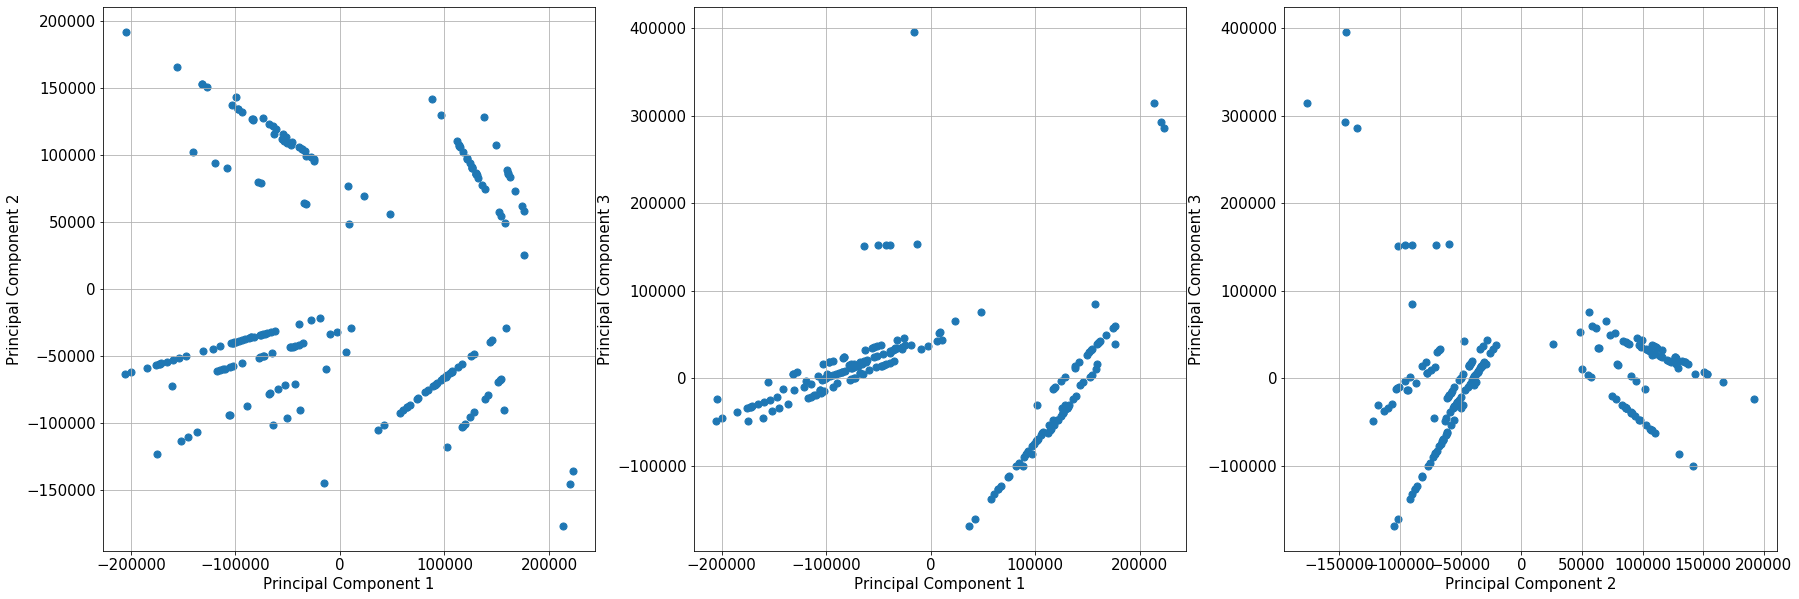

In [98]:

##### Plotting :
fig,axes = plt.subplots(1,3,figsize = (30,10))
   

axes[0].set_xlabel('Principal Component 1', fontsize = 15)
axes[0].set_ylabel('Principal Component 2', fontsize = 15)

axes[1].set_xlabel('Principal Component 1', fontsize = 15)
axes[1].set_ylabel('Principal Component 3', fontsize = 15)

axes[2].set_xlabel('Principal Component 2', fontsize = 15)
axes[2].set_ylabel('Principal Component 3', fontsize = 15)


axes[0].scatter(principalDf.loc[:, 'principal component 1']
               , principalDf.loc[:, 'principal component 2']
               , s = 50)
axes[1].scatter(principalDf.loc[:, 'principal component 1']
               , principalDf.loc[:, 'principal component 3']
               , s = 50)
axes[2].scatter(principalDf.loc[:, 'principal component 2']
               , principalDf.loc[:, 'principal component 3']
                , s = 50)
for i in range(3) :   
    
    axes[i].grid()

When observing the scatter plots, we see the presence of some clusters. Let us analyse the explained variance of each princpical component 

In [99]:
print('The explained variance of each PC :',pca.explained_variance_ratio_)


The explained variance of each PC : [0.45738086 0.27722492 0.18163222]


In [100]:
pca.components_[1]

array([ 1.16403286e-01,  6.90899367e-01, -6.88923387e-01, -1.67699119e-01,
        7.98103566e-02,  5.79609834e-05,  3.49028971e-04, -3.00545170e-04,
       -4.25101053e-05,  3.16997203e-05,  4.03401078e-07, -1.95288816e-07,
        5.03631081e-07, -9.93448973e-08, -3.82024433e-08, -4.68438248e-08,
       -1.91002945e-07, -1.91895239e-08,  4.36157482e-07,  5.83150950e-09,
        1.82648199e-07, -8.45331012e-08,  1.31727682e-07,  2.46080623e-07,
        2.02940033e-07,  2.70579905e-08,  2.75474234e-07, -1.15337929e-07,
       -2.51889533e-08, -1.17430271e-08,  6.56616020e-07, -4.19818150e-07,
        7.53688453e-07,  2.25405540e-07,  2.68754116e-07, -2.19264557e-07,
        2.42368883e-07,  2.82013287e-07,  6.36986602e-09,  4.47837367e-08,
        5.73666438e-08,  4.78903029e-07,  3.95075602e-07, -3.29489095e-07,
        5.76694642e-07,  2.41867829e-08,  2.41817760e-07,  4.34654931e-09,
        5.14795418e-07,  1.10185197e-07,  6.85274072e-08, -1.33643750e-07,
        1.39543727e-08, -

After checking component one and two we conclude that the variance in the data is caused by the net income variables per country. Let us remove these variable and check if there is any change.

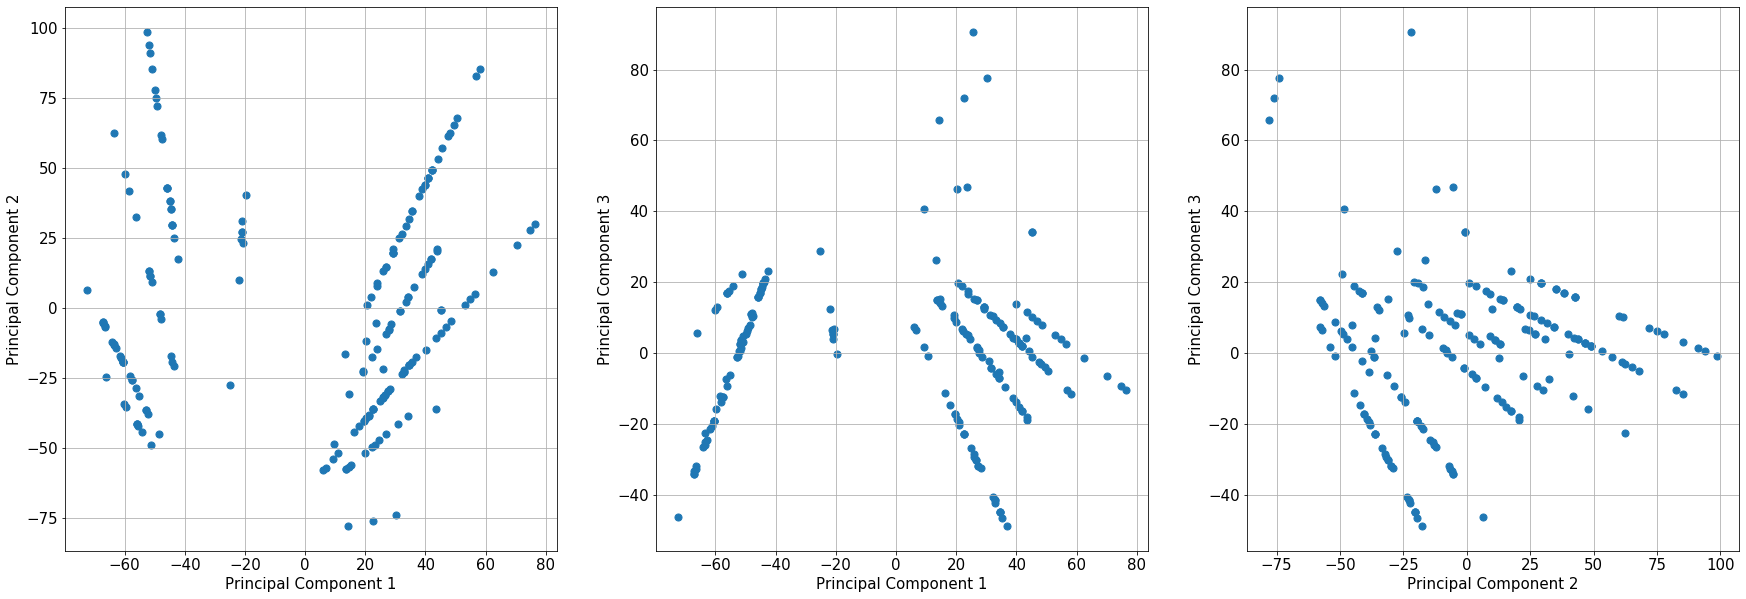

In [101]:
pca = PCA(n_components=3)

pca_data= clients_scores_pivotted.drop(['client_id','CH_net', 'DE_net', 'FR_net', 'LI_net', 'US_net'],axis=1)
principalComponents = pca.fit_transform(pca_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

##### Plotting :
fig,axes = plt.subplots(1,3,figsize = (30,10))
   

axes[0].set_xlabel('Principal Component 1', fontsize = 15)
axes[0].set_ylabel('Principal Component 2', fontsize = 15)

axes[1].set_xlabel('Principal Component 1', fontsize = 15)
axes[1].set_ylabel('Principal Component 3', fontsize = 15)

axes[2].set_xlabel('Principal Component 2', fontsize = 15)
axes[2].set_ylabel('Principal Component 3', fontsize = 15)


axes[0].scatter(principalDf.loc[:, 'principal component 1']
               , principalDf.loc[:, 'principal component 2']
               , s = 50)
axes[1].scatter(principalDf.loc[:, 'principal component 1']
               , principalDf.loc[:, 'principal component 3']
               , s = 50)
axes[2].scatter(principalDf.loc[:, 'principal component 2']
               , principalDf.loc[:, 'principal component 3']
                , s = 50)
for i in range(3) :   
    
    axes[i].grid()

We still have group behaviour even after deleting the net income features. The number of clusters displayed above is not clear. The groups have a line shape.  

In [102]:
print('The explained variance of each PC :',pca.explained_variance_ratio_)


The explained variance of each PC : [0.44693398 0.34482151 0.11484855]


***Scaling all values***

In [103]:
scaler = preprocessing.MinMaxScaler().fit(clients_features.drop(['client_id'],axis=1))

X_scaled = scaler.transform(clients_features.drop(['client_id'],axis=1))
X_scaled = pd.DataFrame(X_scaled, columns = clients_features.drop(['client_id'],axis=1).columns)

***Building the dendogram***

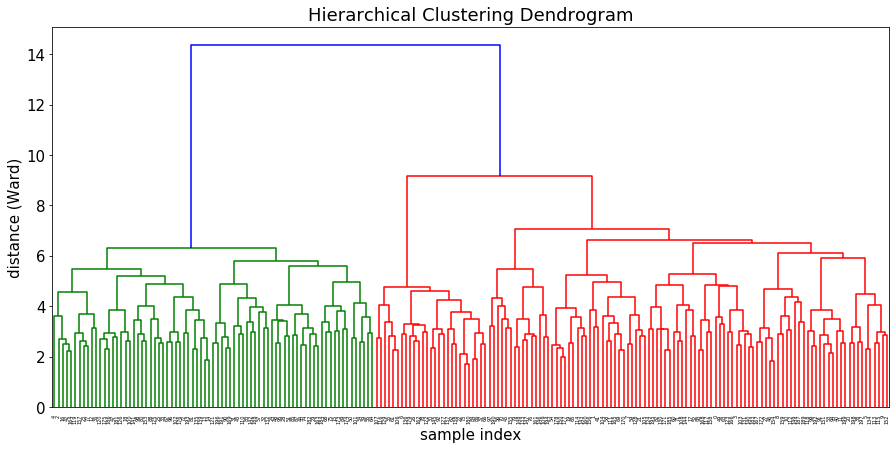

In [104]:
Z = linkage(X_scaled,'ward')

fig = plt.figure(figsize=(15,7))

# Plot title
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z)
# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

plt.show()


We will choose 8 as a distance threshold to get three classes.

In [105]:
clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=8).fit(X_scaled)
clustering.labels_

array([0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       2, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0,
       2, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1,
       1, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 2, 0, 0,
       1, 0, 0, 1, 2, 2, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 2, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0])

In [106]:
clients_features['cluster'] = clustering.labels_

***Checking features separability between clusters***

In [107]:
income_variables = ['CH_net', 'DE_net', 'FR_net', 'LI_net', 'US_net','cluster']

age_variables = ['CH_age', 'DE_age', 'FR_age', 'LI_age', 'US_age','cluster']

sector_type_variables = ['cluster','Bond-Communications',
       'Bond-Consumer Durables', 'Bond-Consumer Non-Durables',
       'Bond-Consumer Services', 'Bond-Distribution Services',
       'Bond-Electronic Technology', 'Bond-Energy Minerals', 'Bond-Finance',
       'Bond-Government', 'Bond-Health Technology', 'Bond-Industrial Services',
       'Bond-Non-Energy Minerals', 'Bond-Process Industries',
       'Bond-Producer Manufacturing', 'Bond-Retail Trade',
       'Bond-Technology Services', 'Bond-Transportation', 'Bond-Utilities',
       'ConvertibleBond-Non-Energy Minerals','cluster',
       'ConvertibleBond-Technology Services', 'Equity-Commercial Services',
       'Equity-Communications', 'Equity-Consumer Durables',
       'Equity-Consumer Non-Durables', 'Equity-Consumer Services',
       'Equity-Distribution Services', 'Equity-Electronic Technology',
       'Equity-Energy Minerals', 'Equity-Finance', 'Equity-Health Services',
       'Equity-Health Technology', 'Equity-Industrial Services',
       'Equity-Miscellaneous', 'Equity-Non-Energy Minerals',
       'Equity-Process Industries', 'Equity-Producer Manufacturing',
       'Equity-Retail Trade', 'Equity-Technology Services',
       'Equity-Transportation', 'Equity-Utilities', 'Fund-Consumer Durables',
       'Fund-Finance', 'Fund-Miscellaneous', 'PerpetualBond-Consumer Durables',
       'PerpetualBond-Energy Minerals', 'PerpetualBond-Finance',
       'PerpetualBond-Process Industries', 'PerpetualBond-Retail Trade',
       'PerpetualBond-Transportation', 'PerpetualBond-Utilities',
       'StructuredAsset-Finance', 'StructuredAsset-Not Classified','cluster']

region_features = ['Africa',
       'Asia', 'Europe', 'Latin America', 'Middle East', 'North America',
       'Pacific','cluster']

***Checking if the clustering is related to the net income of the client*** 

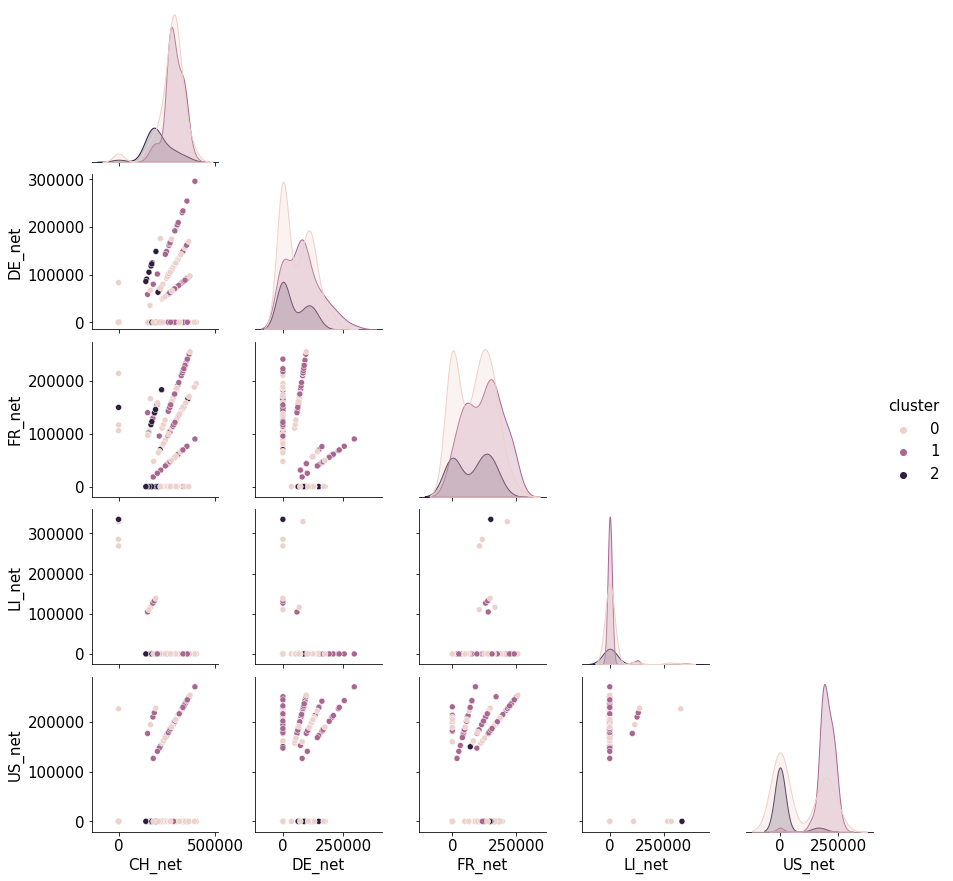

In [108]:
g = sns.pairplot(clients_features[income_variables], hue="cluster",corner=True)

***Cheking if the clustering is related to the type and the sector of the issuer***

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-pac

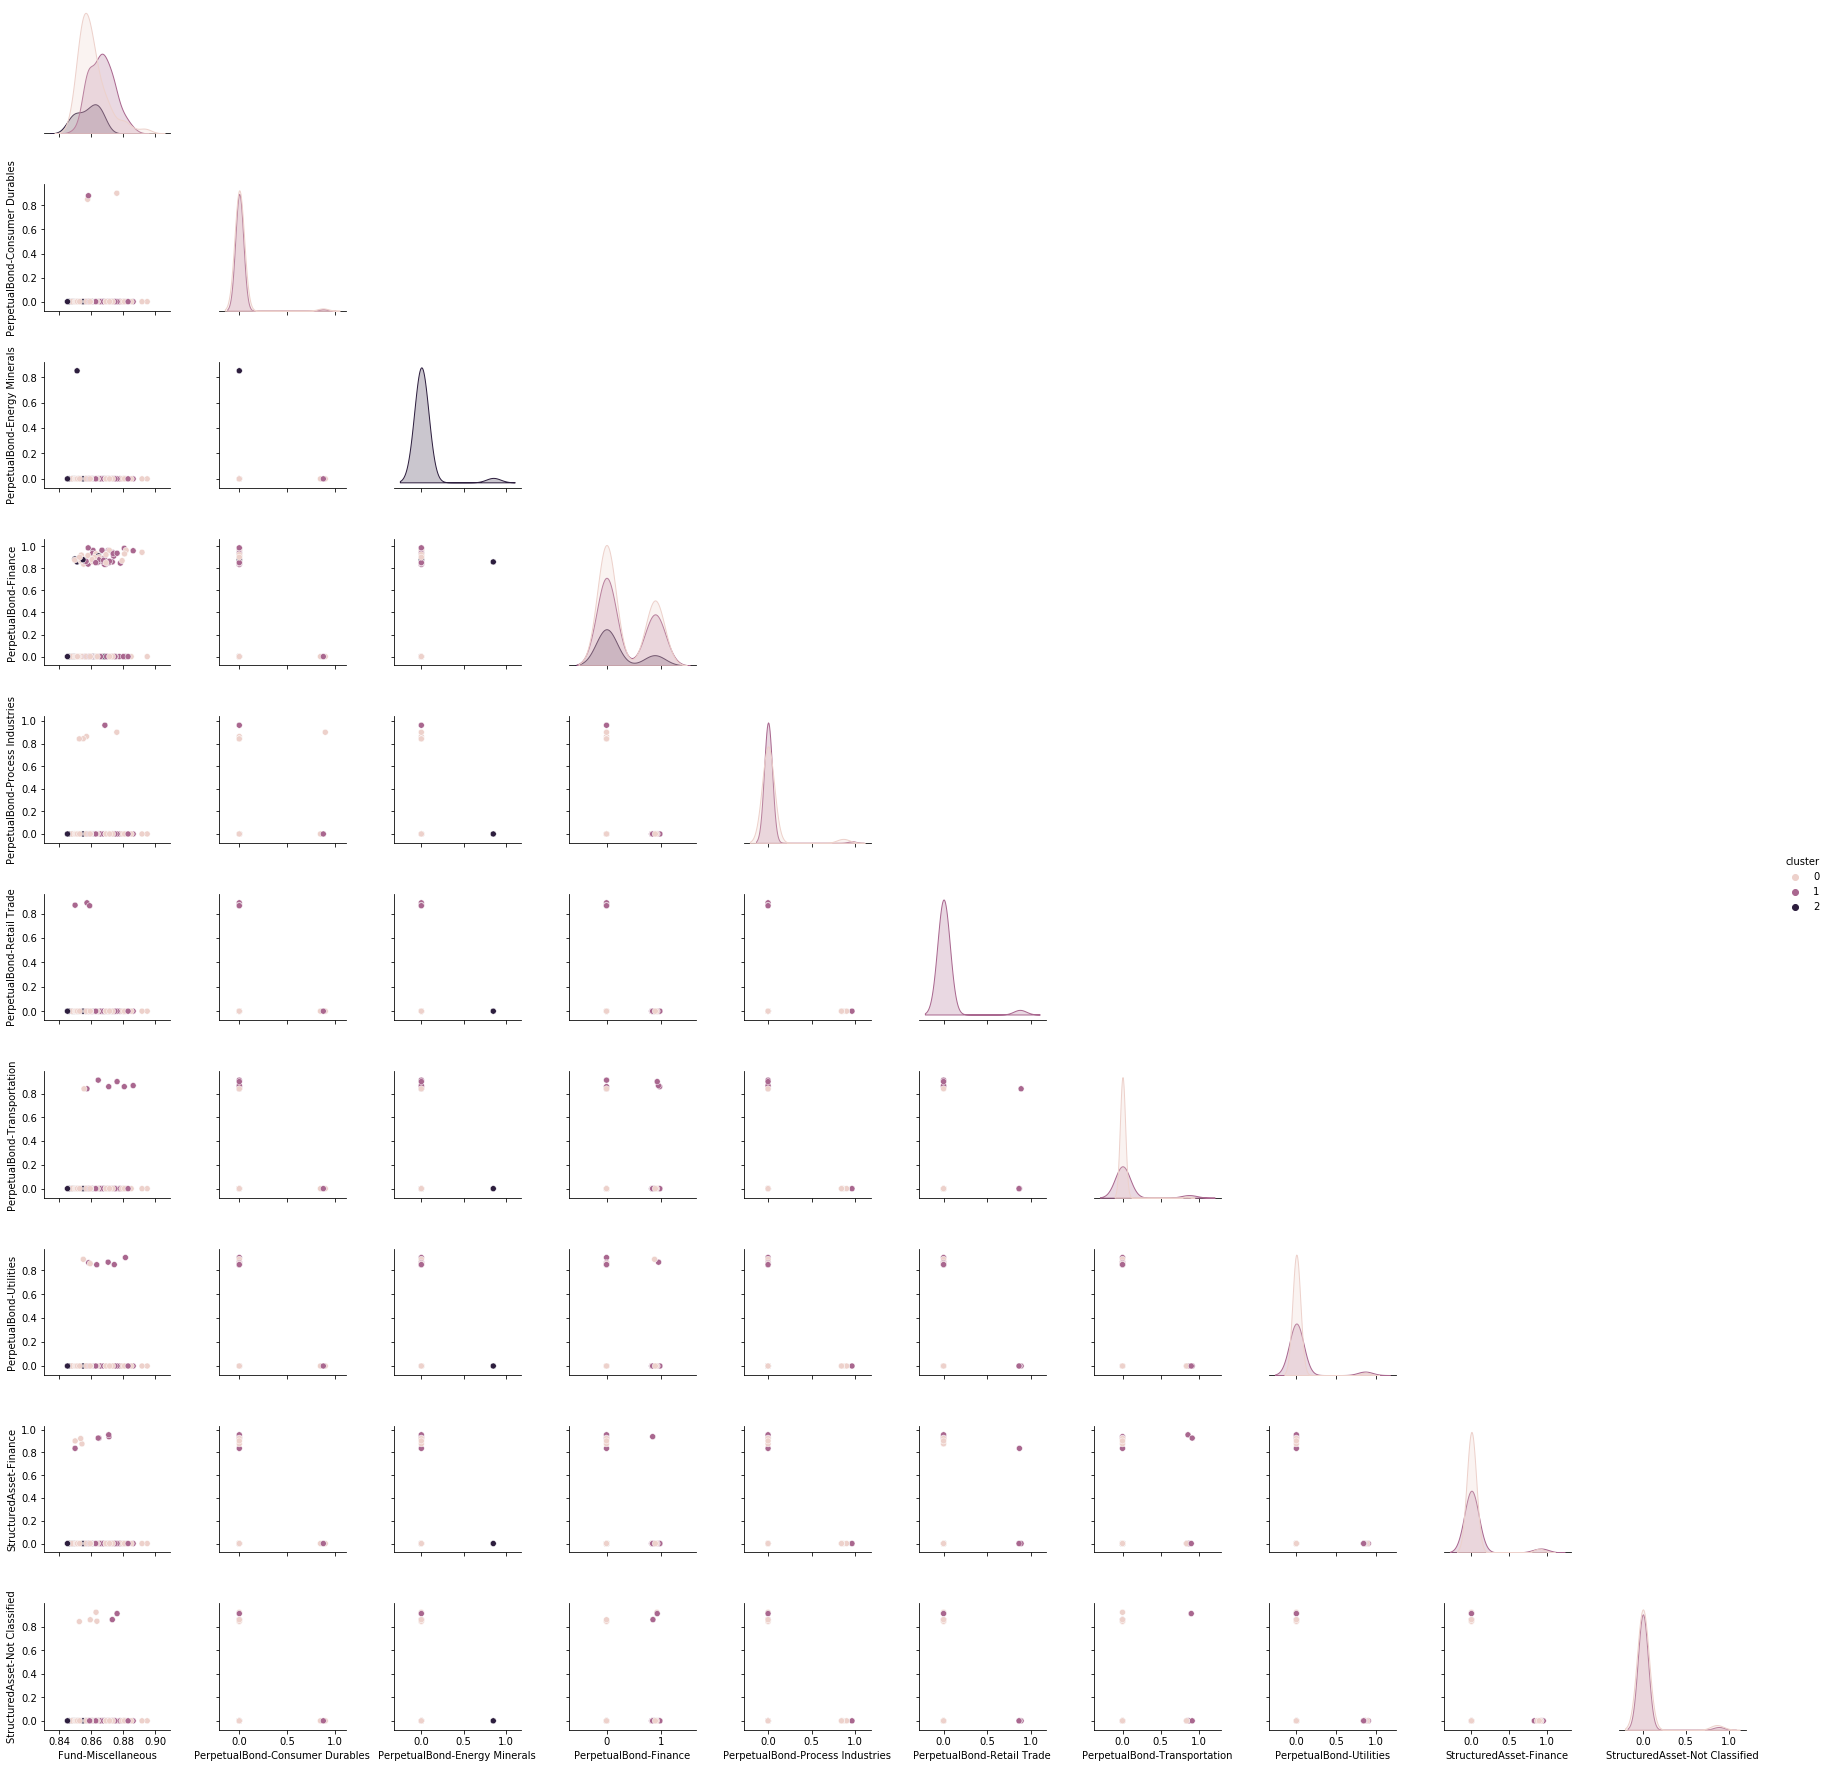

In [109]:
plt.rcParams['font.size'] = '10'

g = sns.pairplot(clients_features[sector_type_variables[44:]], hue="cluster",corner=True)


***Checking is the clustering is related to the region prference of the asset issuer***

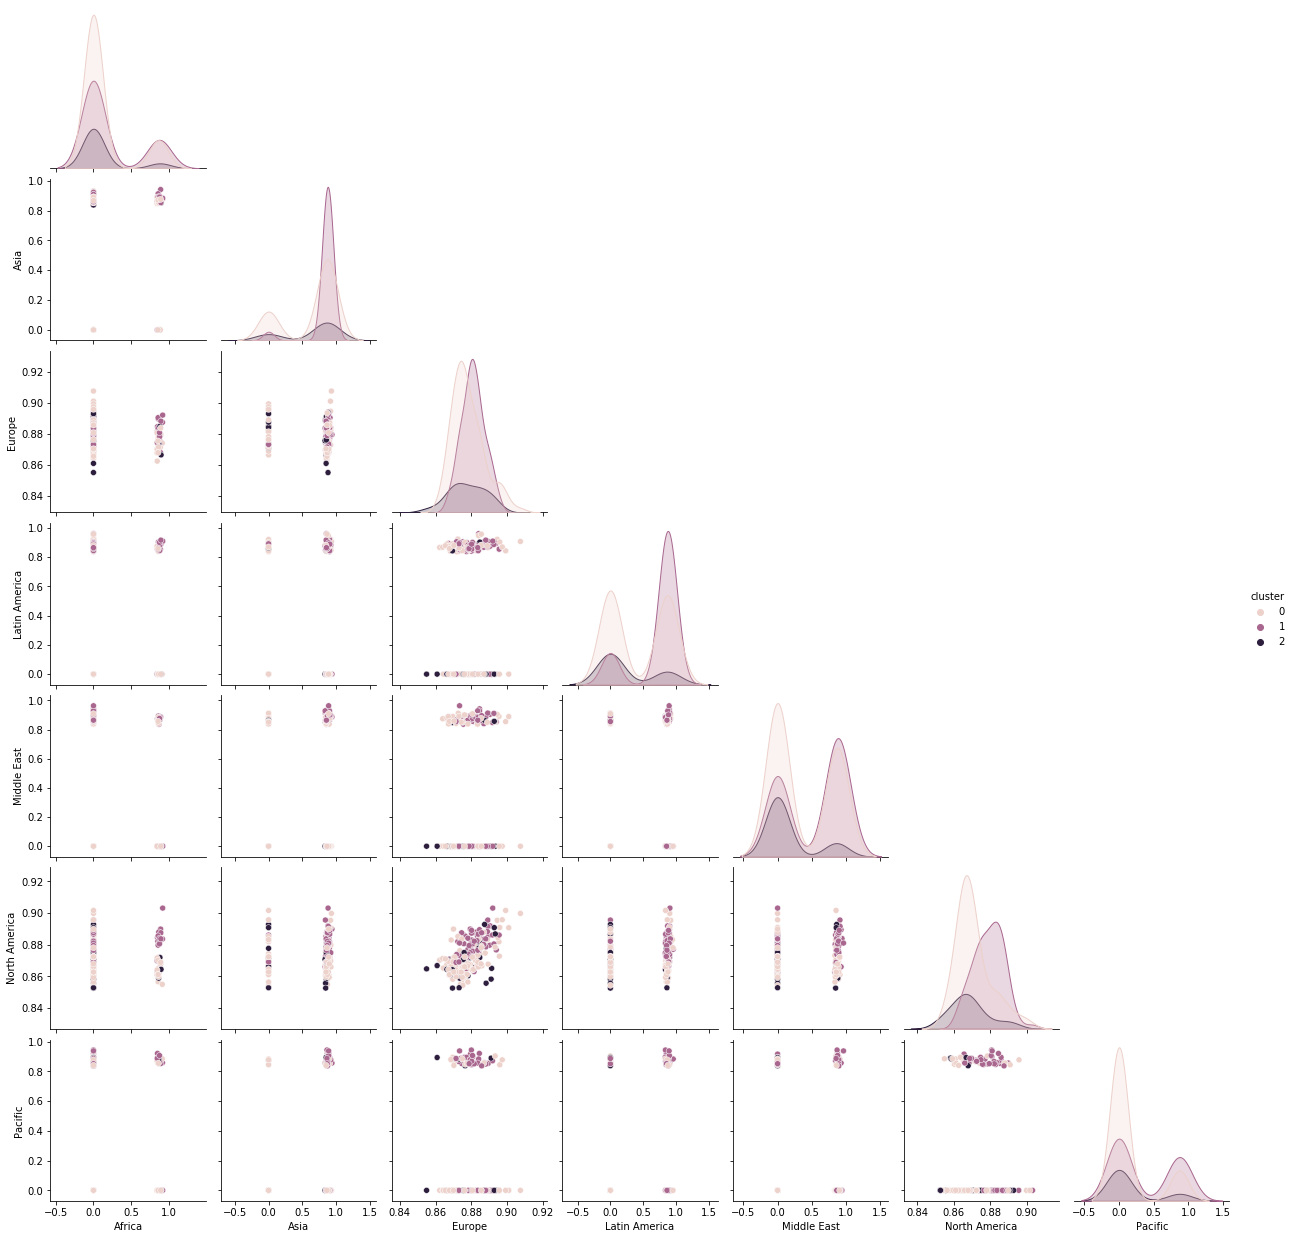

In [110]:
g = sns.pairplot(clients_features[region_features], hue="cluster",corner=True)

***Comments***

We observe that the clusters buildt using the dendogram by fixing a threshold distance 8 do not separate well the features. We can see for example that clients from class 0 tend to be clients reaching a high net income in the US.

We could continue inspecting the variance in the data and try other clustering methods like DBSCAN and other linkage metrics.

## 4) Predict the level of preference a client could have for an instrument

We will keep the same representation as the task before. Given a client and an asset, we will have client oriented features, age_per_country and net_income_per country, and asset oriented features like the type, currency, issuer country and sector of the issuers. All categorical variables will be turned to dummy variables.

After getting the representation we will predict the client preference to a given asset by using a ridge regression.



In [111]:
## Getting Client-asset data

preference_clients_assets = clients_pivotted.merge(preference_asset_issuer, on ='client_id', how='left')

preference_clients_assets.head(3)

,client_id,CH_net,DE_net,FR_net,LI_net,US_net,CH_age,DE_age,FR_age,LI_age,US_age,score,type,currency,name,issuer_name,issuer_country_id,sector_name,region_id
0,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.0,143423.245659,0.0,223423.245659,103.0,0.0,70.0,0.0,65.0,0.918288,Bond,CHF,SWISSAIR GROUP 0.125 2005-07-07,Swissair Group,CH,Transportation,Europe
1,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.0,143423.245659,0.0,223423.245659,103.0,0.0,70.0,0.0,65.0,0.889942,Bond,USD,UNITED STATES OF AMERICA GOVERNMENT OF 0 2020-...,Government of the United States of America,US,Government,North America
2,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.0,143423.245659,0.0,223423.245659,103.0,0.0,70.0,0.0,65.0,0.875873,Fund,USD,Invesco Dynamic Leisure & Entertainment ETF,Invesco Dynamic Leisure & Entertainment ETF,US,Miscellaneous,North America


In [112]:
preference_clients_assets.columns

Index(['client_id', 'CH_net', 'DE_net', 'FR_net', 'LI_net', 'US_net', 'CH_age',
       'DE_age', 'FR_age', 'LI_age', 'US_age', 'score', 'type', 'currency',
       'name', 'issuer_name', 'issuer_country_id', 'sector_name', 'region_id'],
      dtype='object')

In [113]:
columns_to_keep = ['client_id', 'CH_net', 'DE_net', 'FR_net', 'LI_net', 'US_net', 'CH_age','DE_age', 'FR_age', 'LI_age', 'US_age',
                    'name','type','currency','issuer_country_id',
                   'sector_name','score']

preference_clients_assets = preference_clients_assets[columns_to_keep]

In [114]:
preference_clients_assets.head(2)

,client_id,CH_net,DE_net,FR_net,LI_net,US_net,CH_age,DE_age,FR_age,LI_age,US_age,name,type,currency,issuer_country_id,sector_name,score
0,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.0,143423.245659,0.0,223423.245659,103.0,0.0,70.0,0.0,65.0,SWISSAIR GROUP 0.125 2005-07-07,Bond,CHF,CH,Transportation,0.918288
1,002f6006-d9f7-4cfb-4208-fa83274c325a,325134.868488,0.0,143423.245659,0.0,223423.245659,103.0,0.0,70.0,0.0,65.0,UNITED STATES OF AMERICA GOVERNMENT OF 0 2020-...,Bond,USD,US,Government,0.889942


***Model 1 : Ridge regression***

***Train test Split***

In [115]:
clients_assets_features = pd.get_dummies(preference_clients_assets,columns=['type','currency','issuer_country_id', 'sector_name'])

In [116]:
X = clients_assets_features.drop(['client_id','name','score'],axis=1)
y = clients_assets_features['score']

scaler = preprocessing.MinMaxScaler().fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = clients_assets_features.drop(['client_id','name','score'],axis=1).columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

Text(0.5, 1, 'MSE subject to the regularisation parameter')

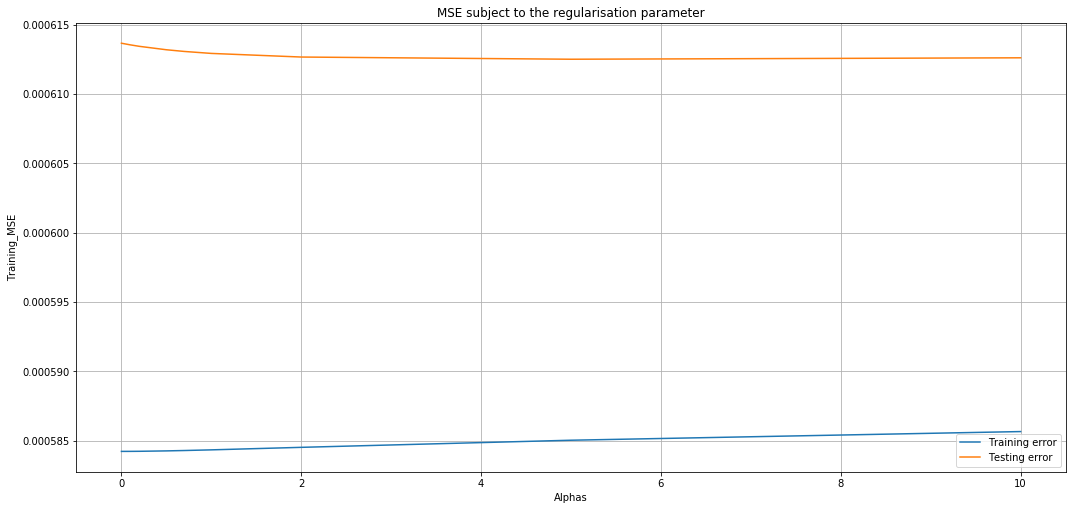

In [117]:
Training_mean_square_errors = []
Testing_mean_square_errors = []

alphas = [0.001,0.01,0.1,0.2,0.5,0.7,1,2,5,10]
for alpha in alphas :
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(X_train,y_train)
    y_train_hat = reg.predict(X_train)
    y_test_hat = reg.predict(X_test)
    Training_mean_square_errors.append(mean_squared_error(y_train, y_train_hat))
    Testing_mean_square_errors.append(mean_squared_error(y_test, y_test_hat))
    
    
plt.figure(figsize=(15,7))

plt.plot(alphas,Training_mean_square_errors, label= 'Training error'  )
plt.plot(alphas,Testing_mean_square_errors , label= 'Testing error'  )


plt.xlabel('Alphas')
 
plt.ylabel('Training_MSE')
plt.grid()
plt.legend()
plt.tight_layout()

plt.title( 'MSE subject to the regularisation parameter' )


***Checking features importance***

In [118]:
reg.coef_

array([ 4.40828681e-04, -4.14322008e-03, -6.26236403e-03,  3.28763573e-03,
        1.04483259e-02, -3.50280235e-03, -8.80087614e-04,  4.34888443e-04,
       -1.87978435e-03,  5.01821115e-03,  2.98756368e-03, -4.03559893e-03,
        8.12498767e-04, -1.20778772e-03, -7.75477970e-03,  4.70236912e-03,
        4.49573477e-03, -6.55220342e-04, -3.04441268e-05,  6.85664468e-04,
        2.22309320e-03,  2.39352449e-03,  4.76544748e-03,  8.90936583e-04,
        5.77135077e-03, -9.02111604e-03,  1.07690240e-02,  7.83543719e-03,
        7.66260790e-04, -4.04181381e-03, -5.23988341e-03,  2.04775862e-03,
        1.14631615e-02,  1.19224816e-02,  3.14292031e-03, -3.68440166e-03,
       -8.66293359e-03, -4.37694968e-04,  1.87371638e-03,  3.13227568e-03,
        5.58200173e-03,  1.37333528e-02,  4.13666749e-03,  2.23042259e-03,
        5.62533781e-04,  6.69383806e-03,  1.36225805e-03,  1.47432150e-03,
        4.25976413e-03,  1.67993684e-03,  6.12952282e-03,  4.92744859e-03,
       -8.01859135e-03, -

In [119]:
Features_ranked_per = X_scaled.columns[ [int(x)-1 for x in ss.rankdata(reg.coef_)]]

In [120]:
TOP_10_features = Features_ranked_per[100:]
TOP_10_features

Index(['CH_age', 'LI_net', 'type_Equity', 'DE_age', 'issuer_country_id_MX',
       'sector_name_Process Industries', 'sector_name_Finance',
       'sector_name_Electronic Technology', 'sector_name_Technology Services',
       'issuer_country_id_NL', 'sector_name_Transportation'],
      dtype='object')

If the investment is in transportation, technology services or from a Dutch issuer it has a higher positive contribution to the preference measure compared to other features.